## I&I

In [1]:
import os
import sys
from collections import Counter
ROOT_DIR = os.path.abspath("/home/gidi/nbs/RoadTrackACC/")
sys.path.append(ROOT_DIR)  # To find local version of the library

In [2]:
from utils import *
from matplotlib import pyplot as plt
import json

%load_ext autoreload
% autoreload 2
%matplotlib inline

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix as cm

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.filterwarnings("ignore")

## load data from key file

In [5]:
key_df = pd.read_csv("/home/gidi/nbs/RoadTrackACC/data/RoadTrack_Experiment_log - Acc_Data.csv")

In [6]:
f=glob.glob(ROOT_DIR+'/data/*.xlsx')
#f=[file for file in f if 'stand' in file]
f=[file for file in f if 'stand' in file or 'Tow' in file]

In [7]:
f

['/home/gidi/nbs/RoadTrackACC/data/Acc_Data_Tow_1605.xlsx',
 '/home/gidi/nbs/RoadTrackACC/data/standStillUphill.xlsx',
 '/home/gidi/nbs/RoadTrackACC/data/standStillDownHill.xlsx',
 '/home/gidi/nbs/RoadTrackACC/data/Acc_Data_Tow_1005.xlsx',
 '/home/gidi/nbs/RoadTrackACC/data/standStillFlat.xlsx']

In [11]:
cd /home/gidi/nbs/RoadTrackACC/

/home/gidi/nbs/RoadTrackACC


In [12]:
# load the sheets from following files
loader =DataLoader()
loader.load_data(f)
big_df = loader.big_df

Loading file:/home/gidi/nbs/RoadTrackACC/data/Acc_Data_Tow_1605.xlsx
Acc_Data_Tow_1605.xlsx Tow_Chevrolet1
Acc_Data_Tow_1605.xlsx Tow_Chevrolet2
Acc_Data_Tow_1605.xlsx Tow_Chevrolet3
Acc_Data_Tow_1605.xlsx Tow_Chevrolet1_Back
Acc_Data_Tow_1605.xlsx Tow_Chevrolet2_Back
Acc_Data_Tow_1605.xlsx Tow_Chevrolet3_Back
Acc_Data_Tow_1605.xlsx Tow_Nissan1
Acc_Data_Tow_1605.xlsx Tow_Nissan2
Acc_Data_Tow_1605.xlsx Tow_Nissan3
Acc_Data_Tow_1605.xlsx Tow_Nissan1_Back
Acc_Data_Tow_1605.xlsx Tow_Nissan2_Back
Acc_Data_Tow_1605.xlsx Tow_Nissan3_Back
Acc_Data_Tow_1605.xlsx Tow_Toyota1
Acc_Data_Tow_1605.xlsx Tow_Toyota2
Acc_Data_Tow_1605.xlsx Tow_Toyota3
Acc_Data_Tow_1605.xlsx Tow_Toyota1_Back
Acc_Data_Tow_1605.xlsx Tow_Toyota2_Back
Acc_Data_Tow_1605.xlsx Tow_Toyota3_Back
Loading file:/home/gidi/nbs/RoadTrackACC/data/standStillUphill.xlsx
standStillUphill.xlsx standStillUphill
Loading file:/home/gidi/nbs/RoadTrackACC/data/standStillDownHill.xlsx
standStillDownHill.xlsx standStillDownHill
Loading file:/home

In [13]:
config = json.load(codecs.open(ROOT_DIR+'/config.json', 'r', 'utf-8-sig'))

In [14]:
key_df = pd.read_csv(config['experiment_key_file'])

KeyError: 'experiment_key_file'

## Analysis

### Tests

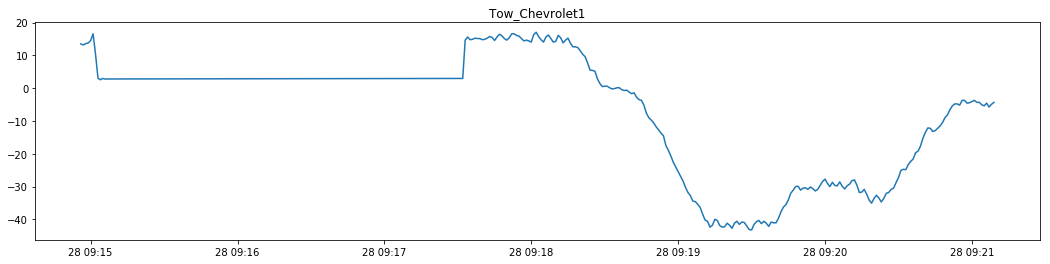

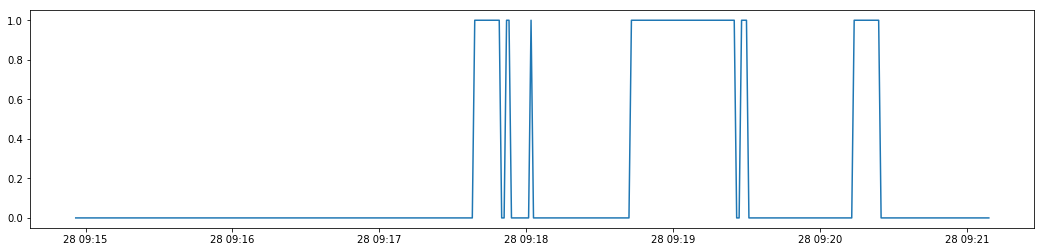

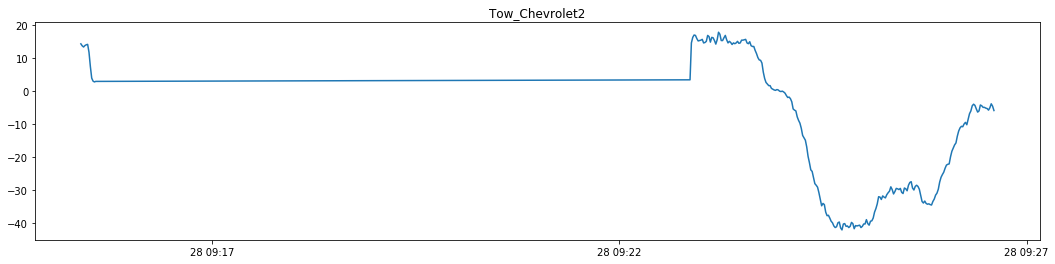

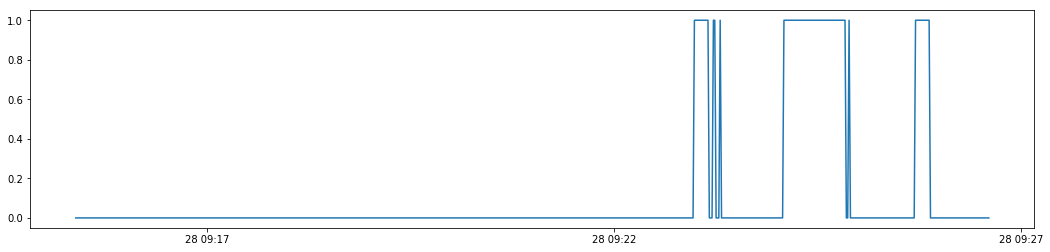

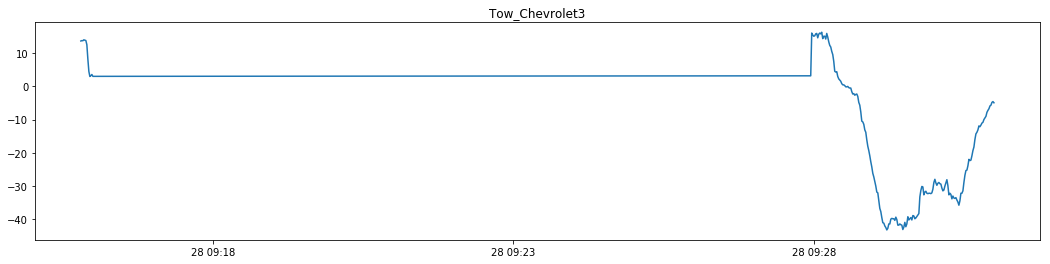

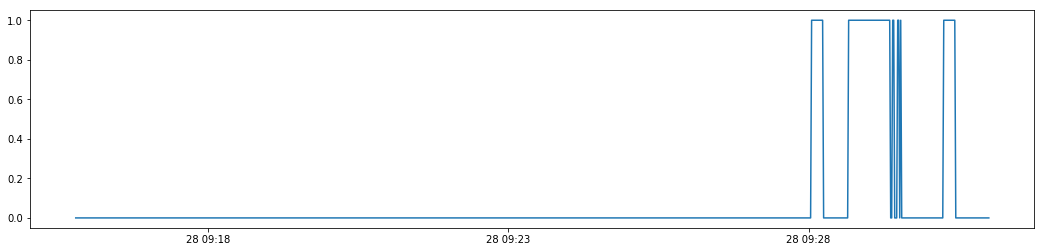

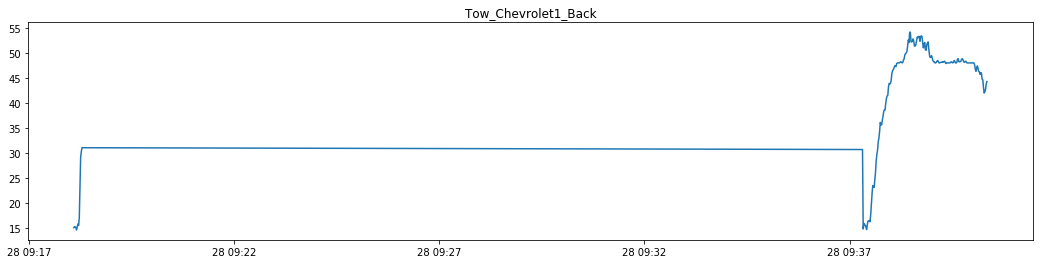

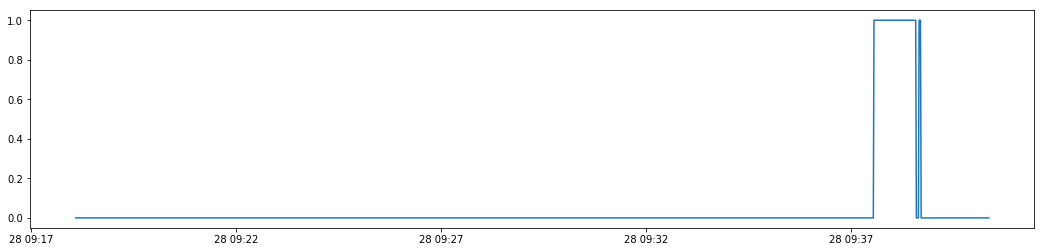

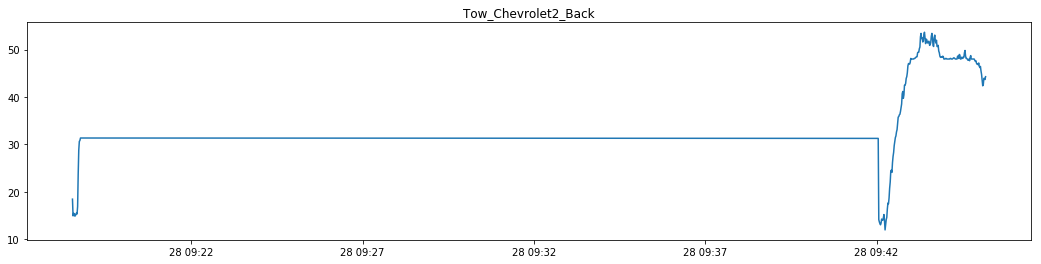

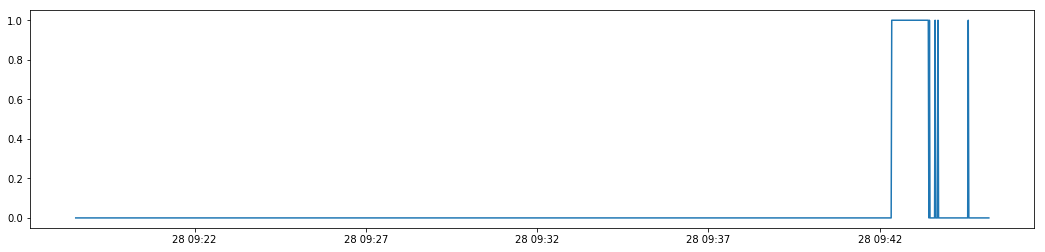

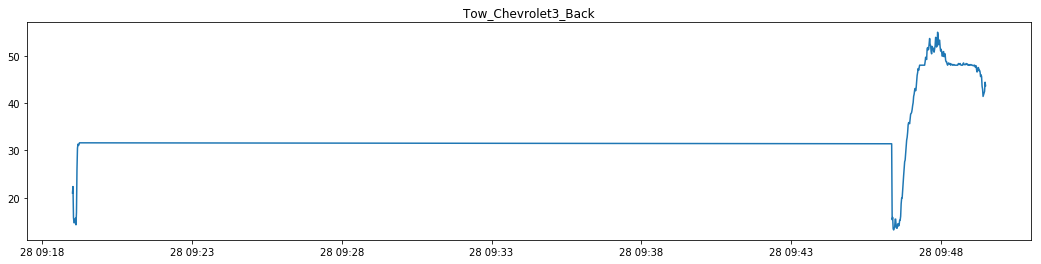

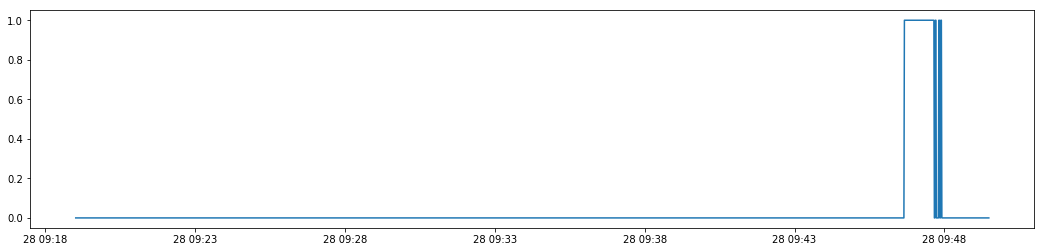

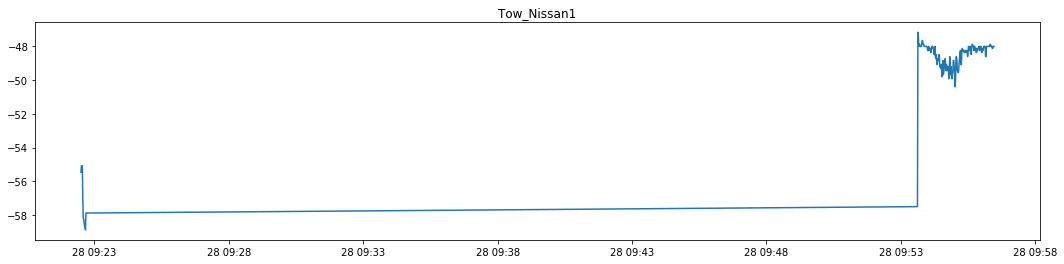

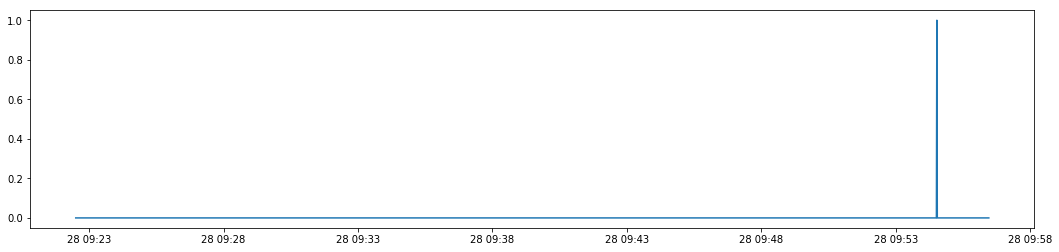

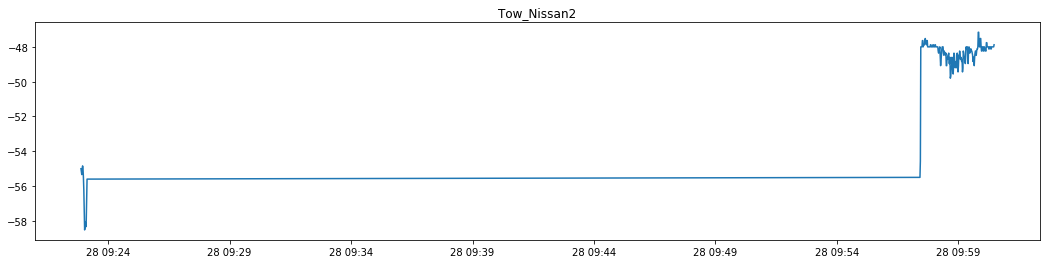

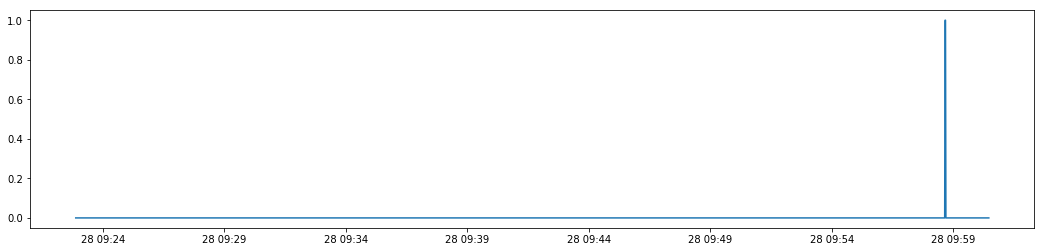

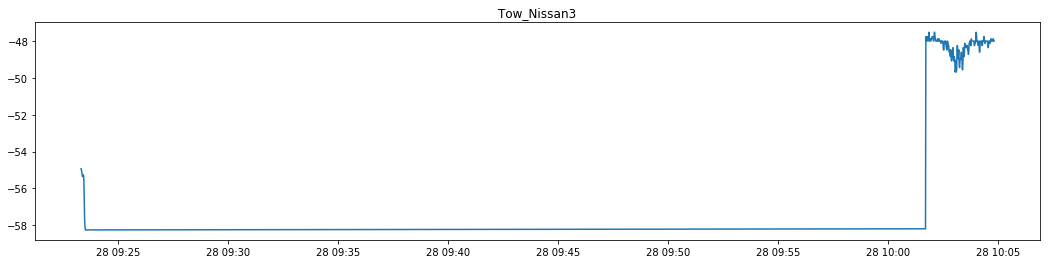

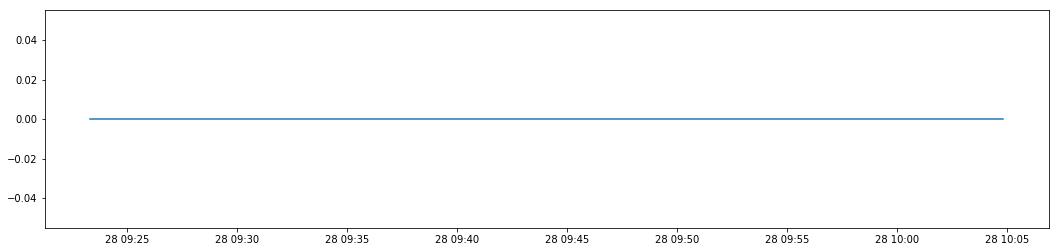

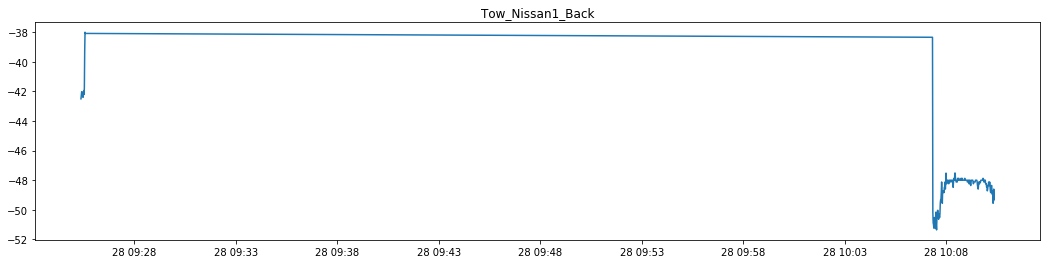

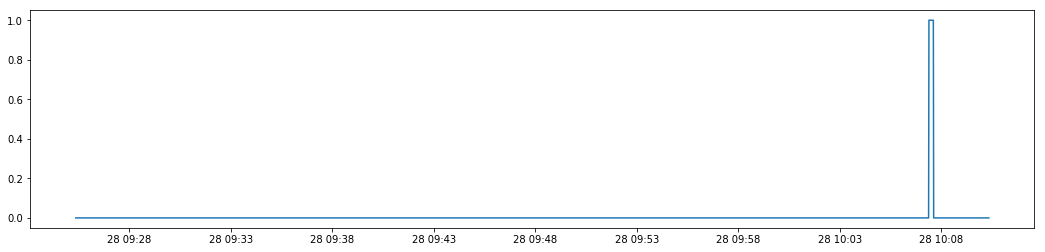

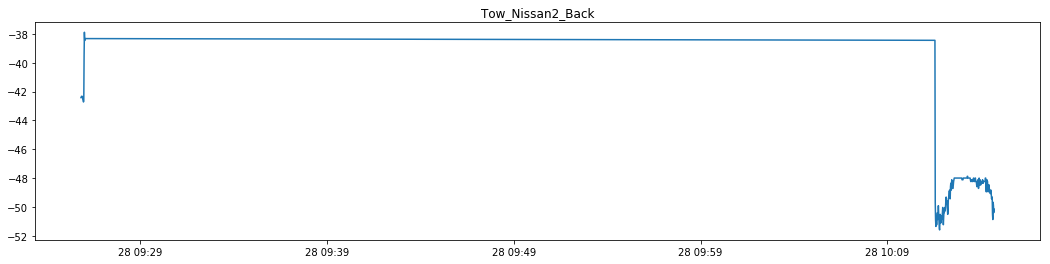

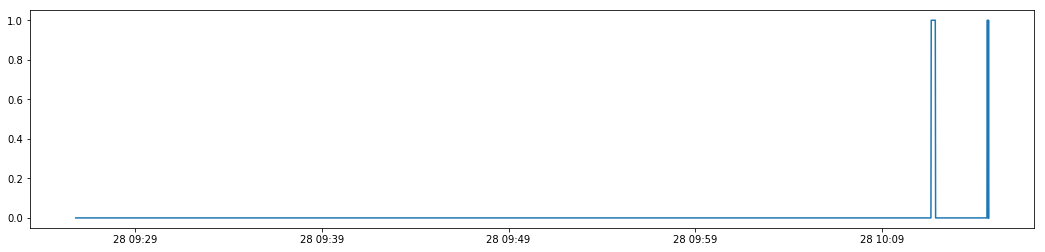

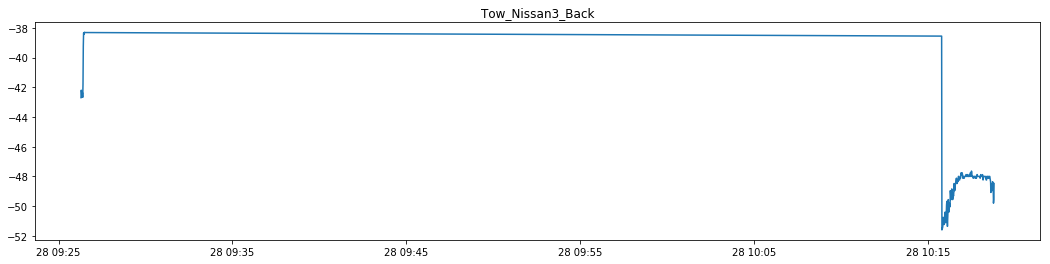

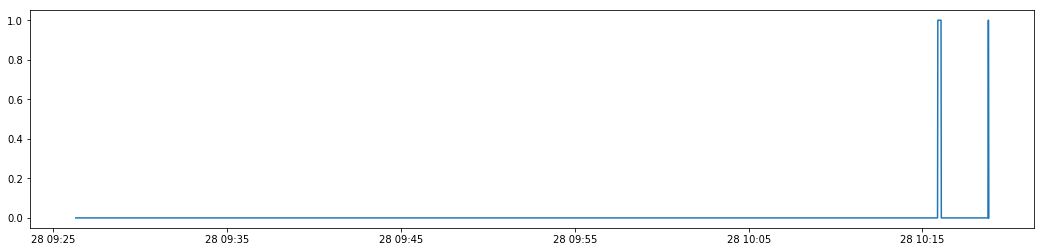

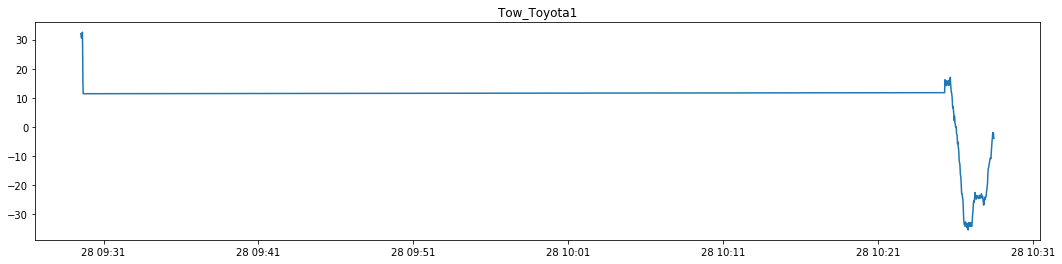

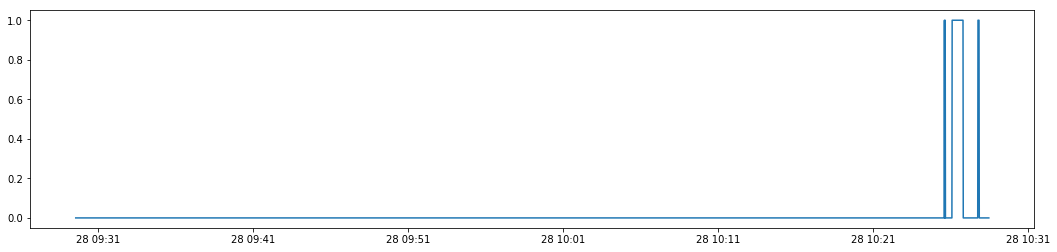

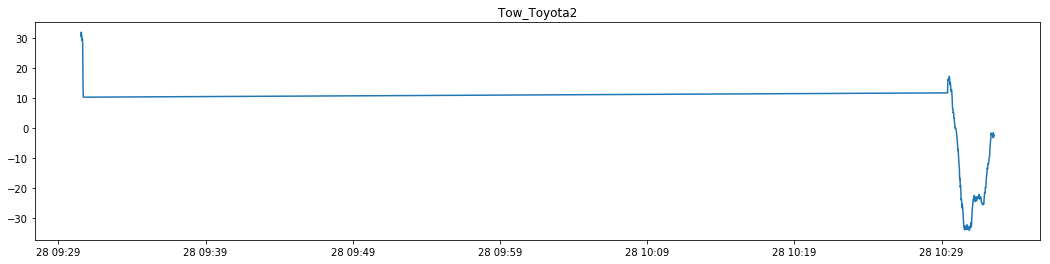

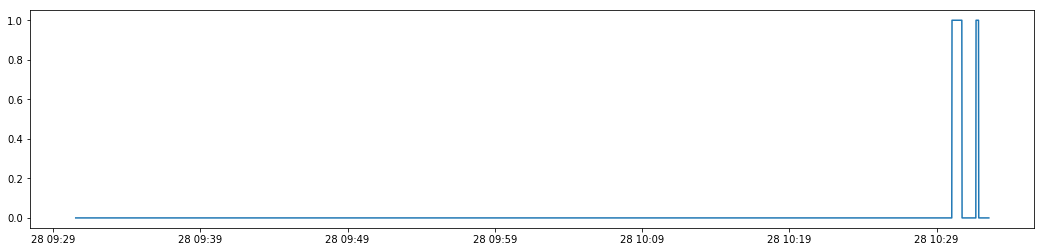

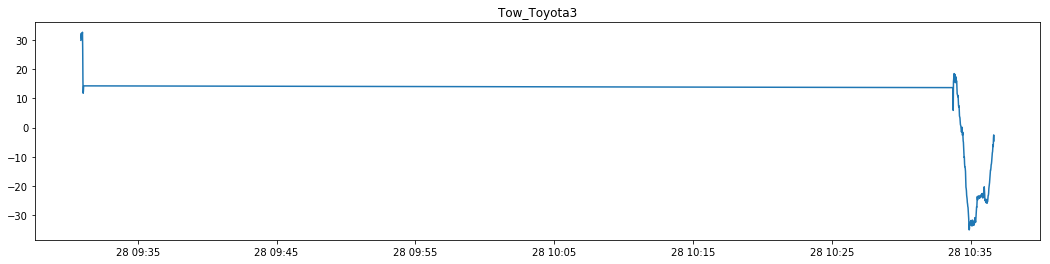

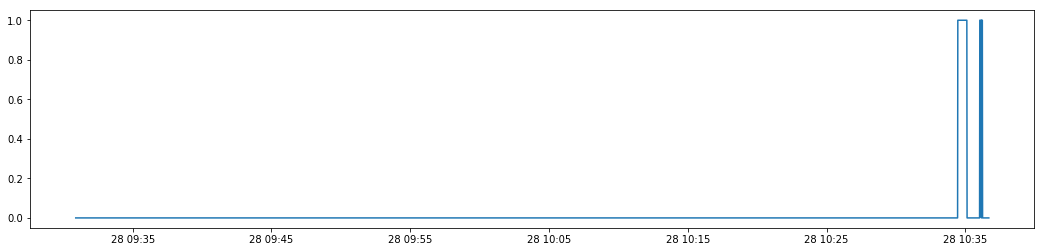

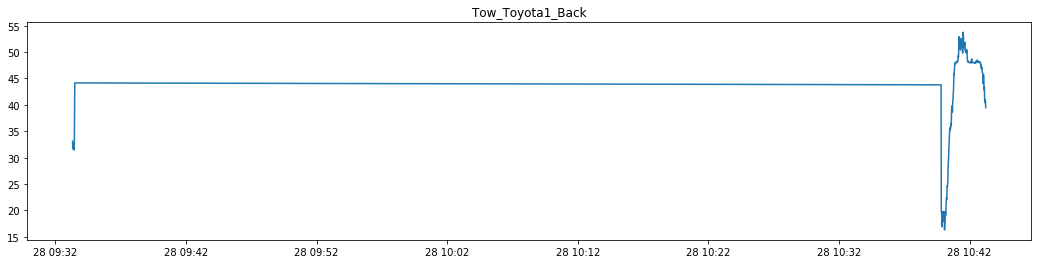

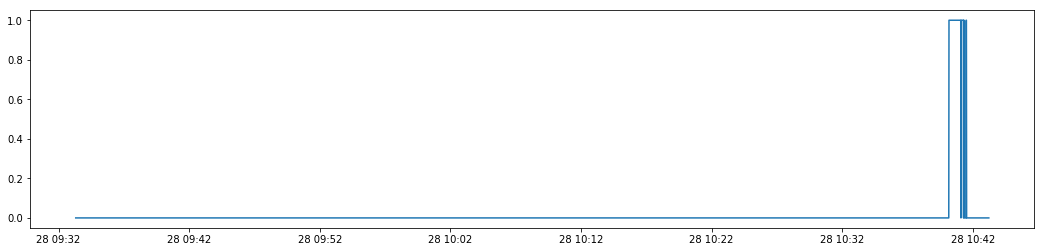

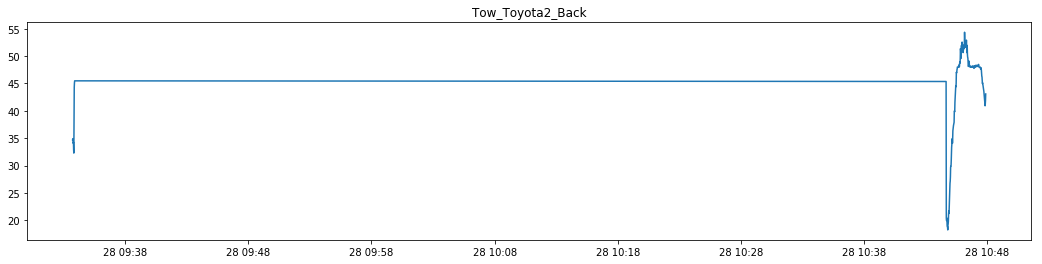

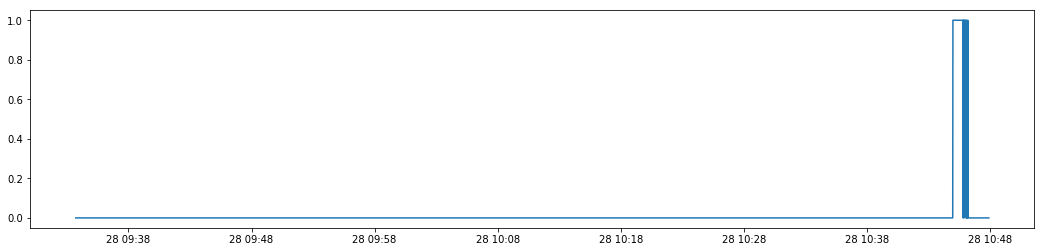

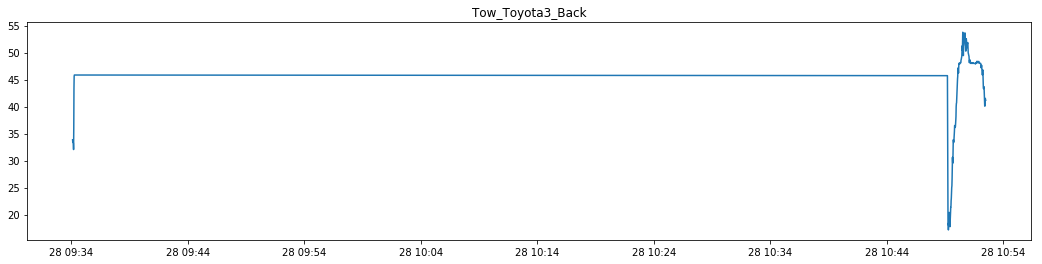

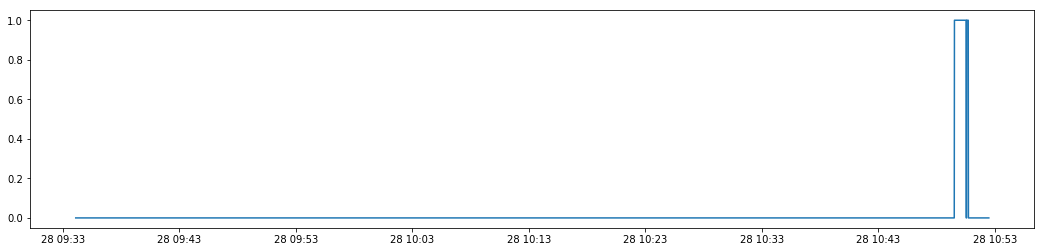

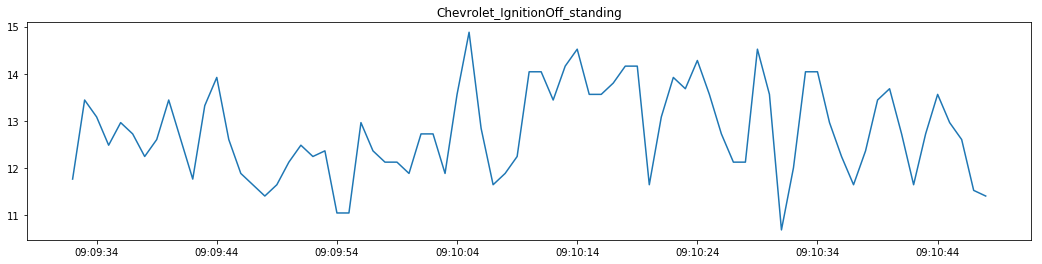

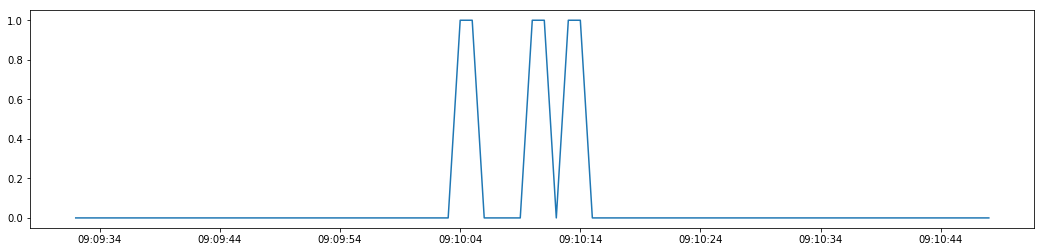

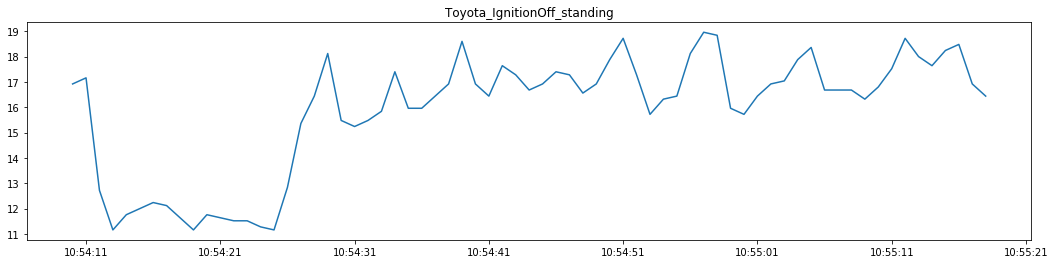

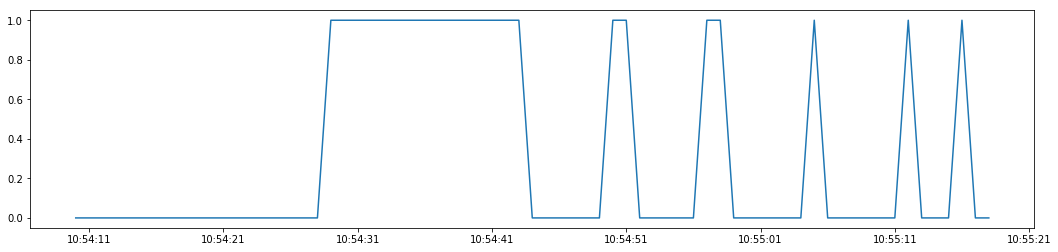

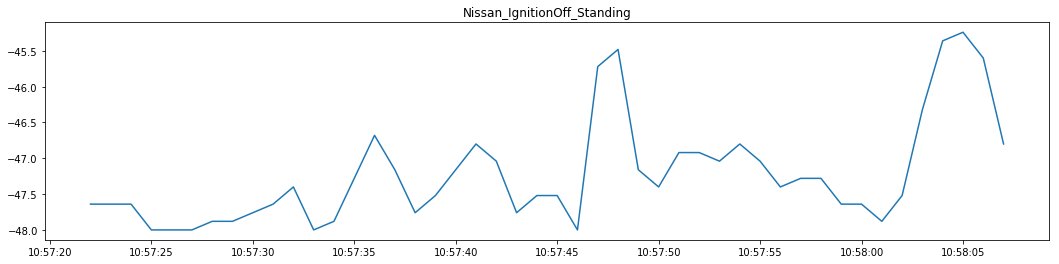

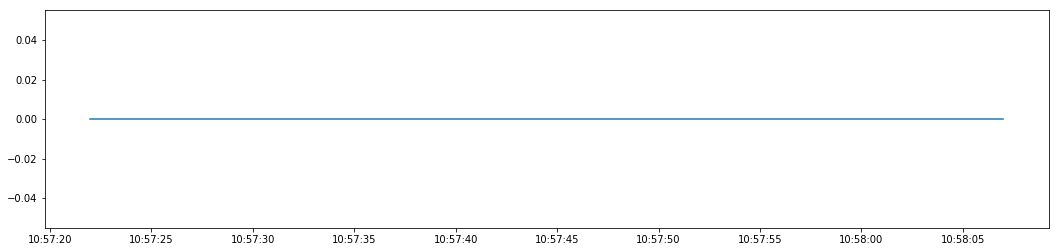

In [44]:
# some kind of groupings
grouped_list=[]
for sheet in list(big_df.sheet.unique()):
    forward_rolling = pd.DataFrame(big_df[big_df.sheet==sheet].Forward.rolling(100).mean()) # 100RollingMean
    forward_rolling['time_sec'] = forward_rolling.index.round('s')
    forward_grouped = forward_rolling.groupby('time_sec').agg({'Forward':['first','last']})

    declines =pd.Series([ i[1].Forward['first']>i[1].Forward['last']+1 for i in forward_grouped.iterrows() ])
    increases =pd.Series([ i[1].Forward['first']<i[1].Forward['last']-1 for i in forward_grouped.iterrows() ])

    forward_grouped['consecutive_dec']=list(declines * (declines.groupby((declines != declines.shift()).cumsum()).cumcount() + 1))
    forward_grouped['consecutive_inc']=list(increases * (increases.groupby((increases != increases.shift()).cumsum()).cumcount() + 1))
    
    fig,ax = plt.subplots(figsize=(18,4))
    ax.plot(forward_grouped.Forward['first'])
    #ax.plot(forward_grouped.consecutive_inc)
    ax.set_title(sheet)
    
    #ax.plot(forward_grouped.Forward)
    #ax.plot(forward_grouped.Forward[::5],marker='.', linestyle='None', markersize = 10.0)
    
    grouped_list.append(forward_grouped)
    
    consec=0
    j=forward_grouped.Forward[::5]['first'][0]
#     for i in forward_grouped.Forward[::5]['first']:
#         if i+0.5<j:
#             consec+=1
#         else:
#             consec=0
#         print(consec)
#         j=i

    # print uptrends
    fig,ax = plt.subplots(figsize=(18,4))
    mean = forward_grouped.Forward['first'].rolling(20).mean()
    std = forward_grouped.Forward['first'].rolling(20).std()
    ax.plot(np.abs(forward_grouped.Forward['first'])>np.abs(mean)+1)
    #print((np.abs(forward_grouped.Forward['first'])>np.abs(mean)+np.abs(std)))
    plt.show()

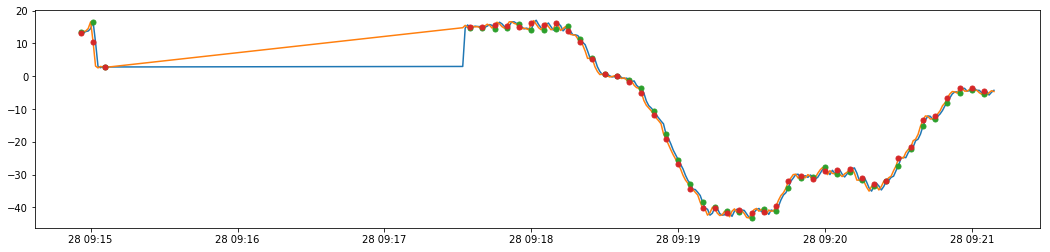

In [45]:
fig,ax = plt.subplots(figsize=(18,4))
ax.plot(grouped_list[0].Forward)
ax.plot(grouped_list[0].Forward[::5],marker='.', linestyle='None', markersize = 10.0)

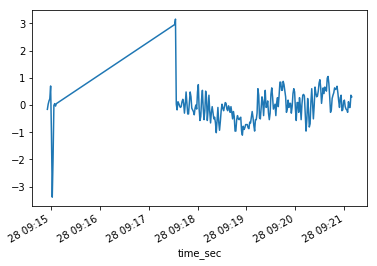

In [46]:
tmp = grouped_list[0].Forward['first']
pd.Series(np.gradient(tmp.values,2), tmp.index, name='slope').plot()

/home/gidi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=24,min_periods=0,adjust=True,ignore_na=False).mean()
  


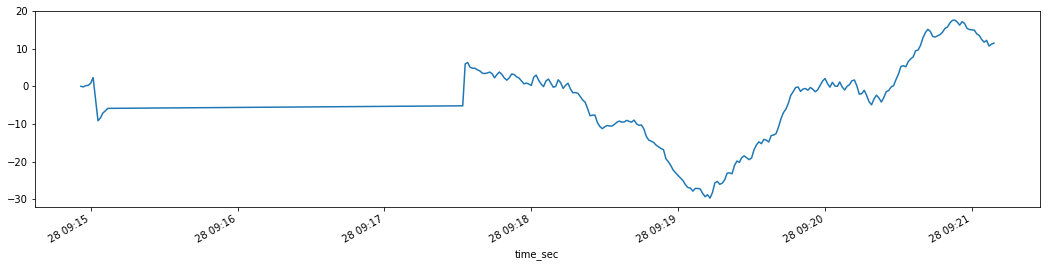

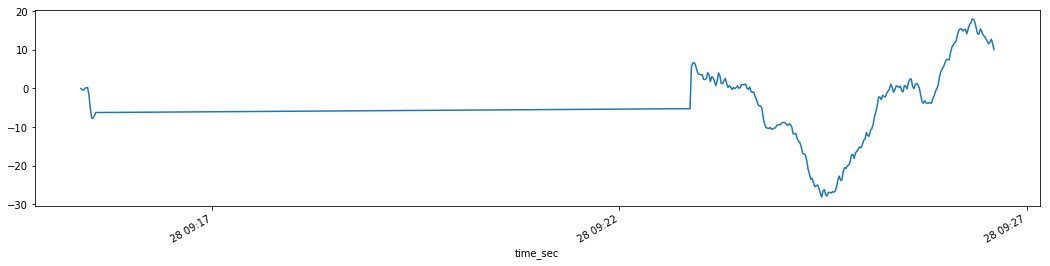

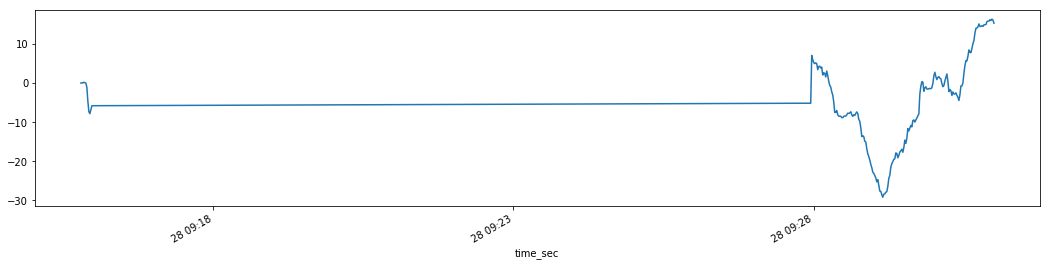

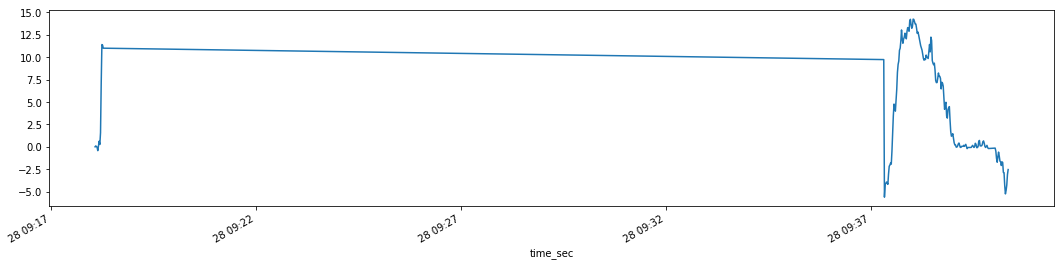

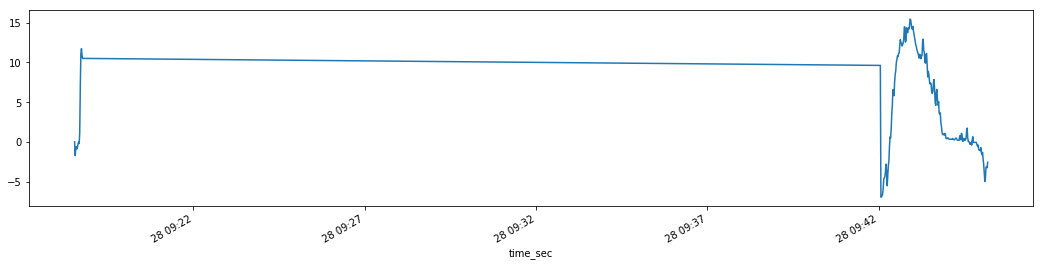

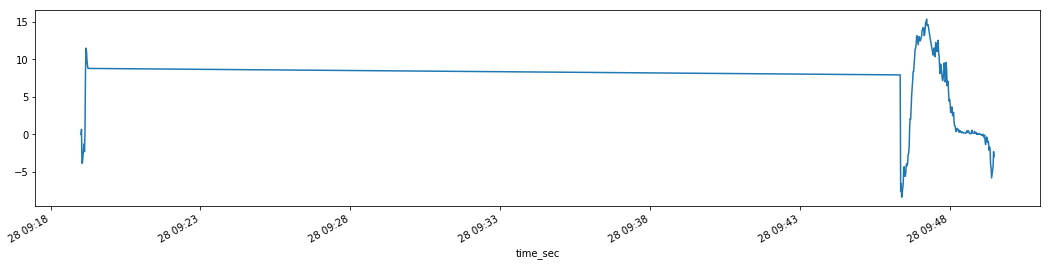

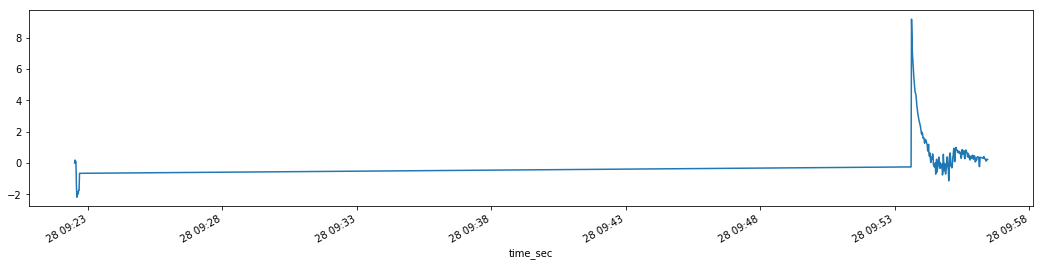

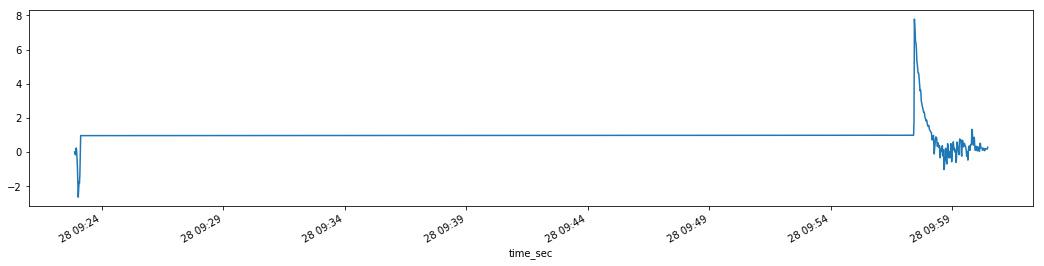

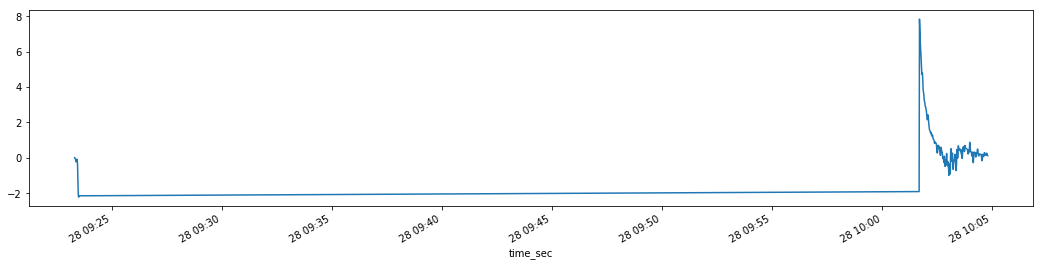

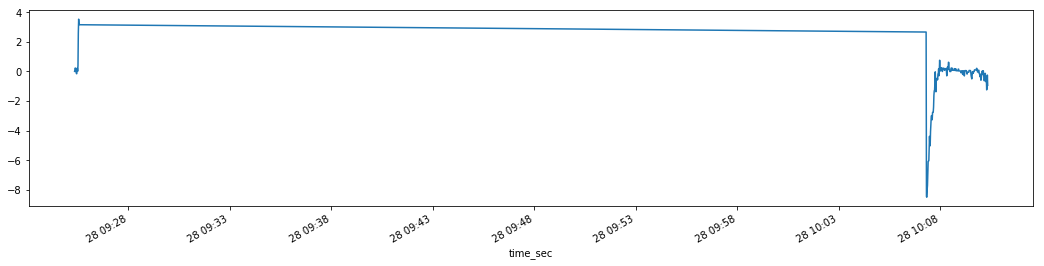

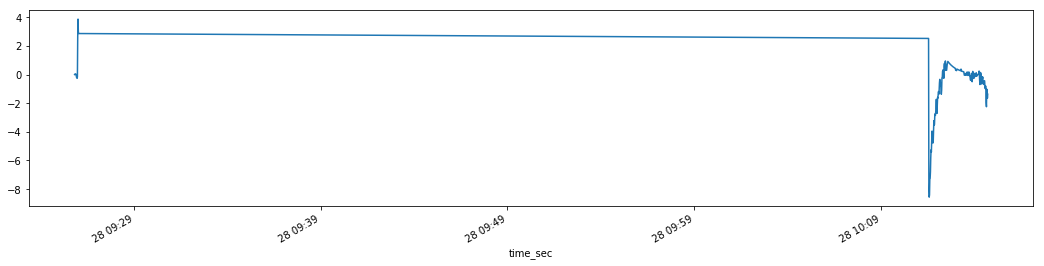

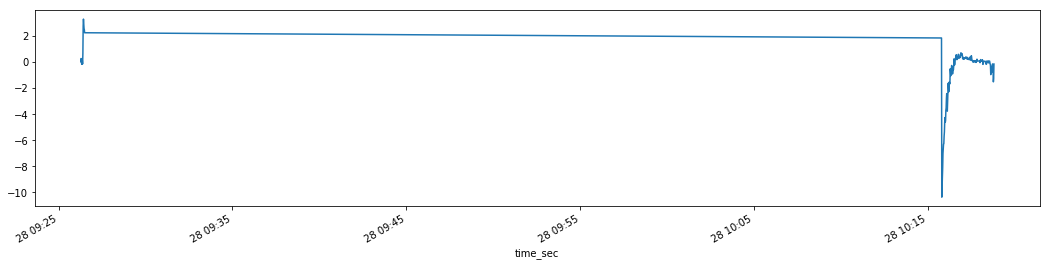

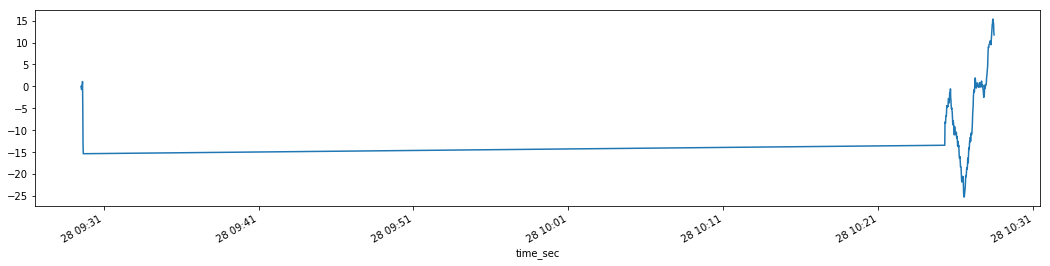

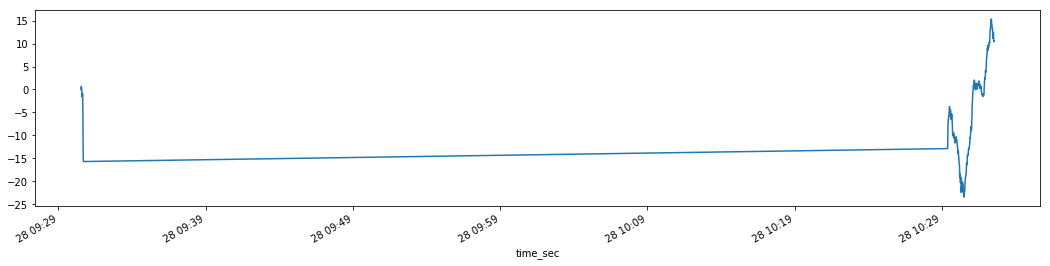

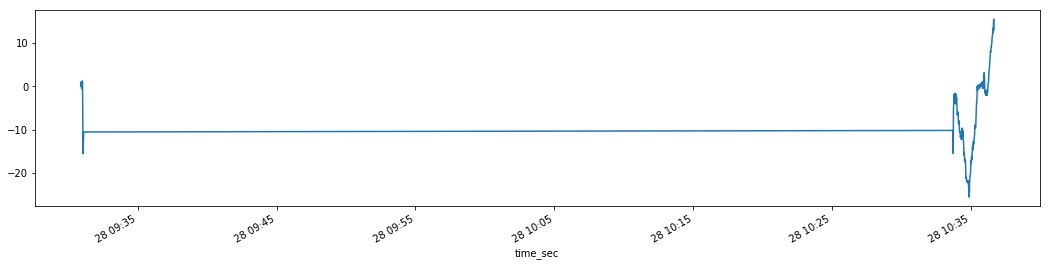

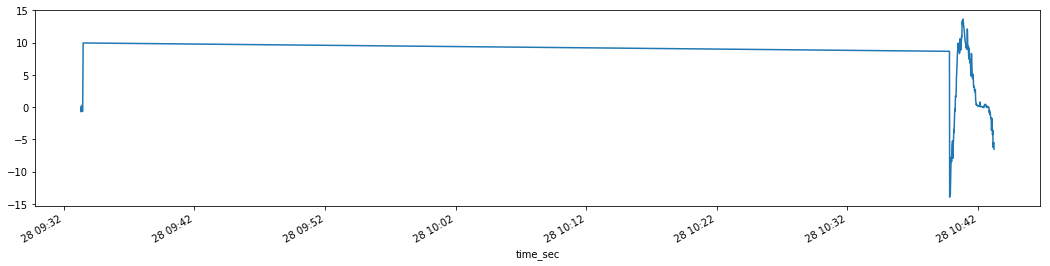

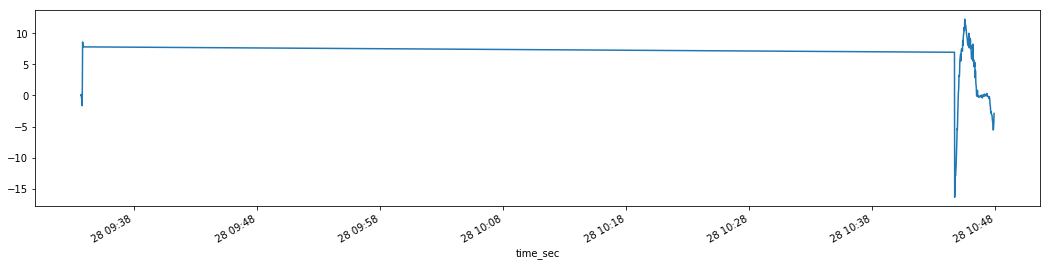

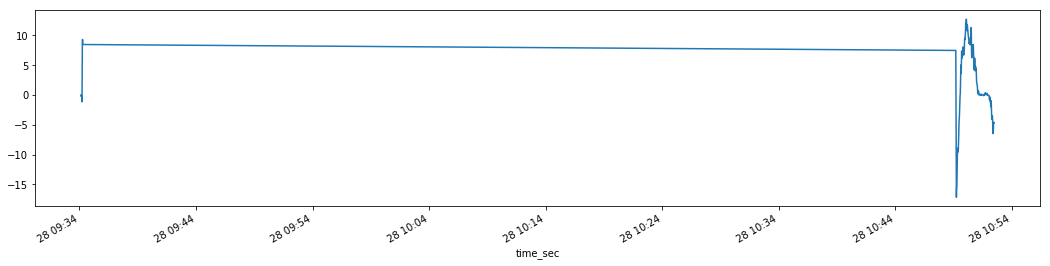

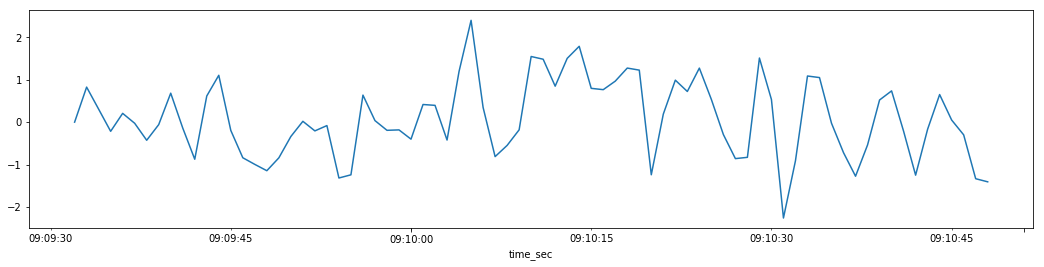

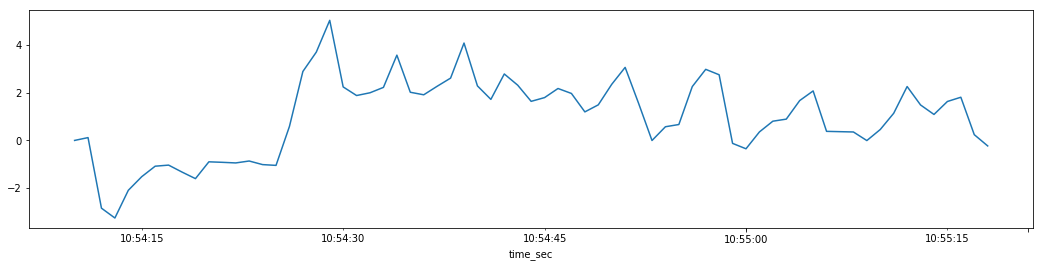

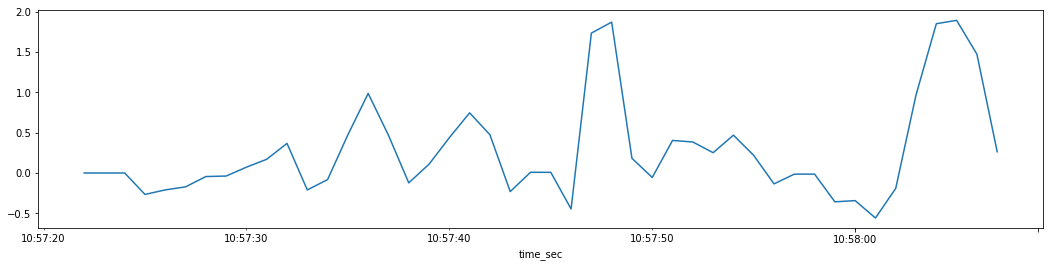

In [47]:
for df in grouped_list:
    fig,ax = plt.subplots(figsize=(18,4))
    #ax.plot(forward_grouped.consecutive_dec)
    #ax.plot(forward_grouped.consecutive_inc)
    #ax.set_title(sheet)
    
    #(df.Forward['first']-df.Forward['first'].rolling(10).mean()).plot()
    (df.Forward['first']-pd.ewma(df.Forward['first'], halflife=24)).plot()
    plt.show()

/home/gidi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.


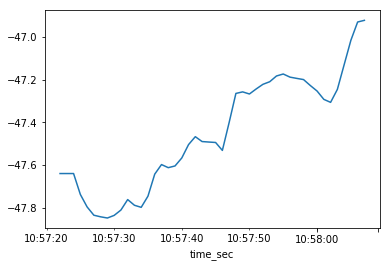

In [246]:
 pd.ewma(df.Forward['first'], halflife=12)

In [232]:
def consecutive_move(data):
    decreases=[pred < current for current,pred in zip(data,[data[0]]+data[:-1]) ]
    increases=[pred > current for current,pred in zip(data,[data[0]]+data[:-1]) ]
    consec_decreases = decreases * (decreases.groupby((decreases != decreases.shift()).cumsum()).cumcount() + 1)
    consec_increases = increases * (increases.groupby((increases != increases.shift()).cumsum()).cumcount() + 1)
    return consec_decreases

In [233]:
consecutive_move(list(forward_grouped.Forward[::5]['first']))

AttributeError: 'list' object has no attribute 'groupby'

In [236]:
consec=0
j=grouped_list[0].Forward[::5]['first'][0]
for i in grouped_list[0].Forward[::5]['first']:
    if i<j:
        consec+=1
    else:
        consec=0
    print(consec)
    j=i

0
0
0
0
0
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
0
1
0
0
0
1
0
0
0
1
2
0
0
0
0
0
0
0
1
2


In [171]:
declines =pd.Series([ i[1].Forward['first']>i[1].Forward['last']+1 for i in forward_grouped.iterrows() ])
increases =pd.Series([ i[1].Forward['first']<i[1].Forward['last']-1 for i in forward_grouped.iterrows() ])

In [172]:
forward_grouped['declines']=declines[0]
forward_grouped['increases']=increases[0]



In [174]:
forward_grouped['consecutive_dec']=list(declines * (declines.groupby((declines != declines.shift()).cumsum()).cumcount() + 1))
forward_grouped['consecutive_inc']=list(increases * (increases.groupby((increases != increases.shift()).cumsum()).cumcount() + 1))

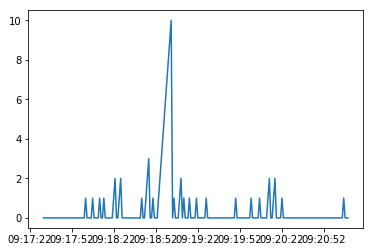

In [175]:
plt.plot(forward_grouped.consecutive_dec)

In [28]:
a=big_df[big_df.sheet=='Tow_Chevrolet1'].Forward.rolling(100).mean()

## Winning feature extraction

This logic can identify the long, significant towings, but not the short "2 wheel" towings

In [363]:
big_df=stand_df

In [15]:
def mean_crossing(big_df, first_level=100, second_level=10, consec_thresh=25,axis='Forward'):
    # this is function return the maximum consecutive mean corssing, with 2 
    # rolling means
    for row in big_df[['sheet','file']].drop_duplicates().iterrows(): 
        sheet = row[1][0]
        file = row[1][1]
        rolling = pd.DataFrame(big_df[(big_df.sheet==sheet)&(big_df.file==file)][axis].rolling(first_level).mean())
        rolling['time_sec'] = rolling.index.round('s')

        grouped = rolling.groupby('time_sec').mean()
        mean = grouped[axis].rolling(second_level).mean()
        trend = pd.DataFrame(np.abs(grouped[axis])>np.abs(mean)+1)[axis]
        consec_decreases = trend * (trend.groupby((trend != trend.shift()).cumsum()).cumcount() + 1)
        
        fig,ax = plt.subplots(figsize=(18,4))
        ax.plot(grouped[axis])
        ax.set_title(sheet+' consec:'+str(max(consec_decreases)))
        ax.plot(mean)
        ax.plot(trend*10)

In [27]:
1+1

2

0
tow Tow_Chevrolet1 Acc_Data_Tow_1605.xlsx
0
tow Tow_Chevrolet2 Acc_Data_Tow_1605.xlsx
0
tow Tow_Chevrolet3 Acc_Data_Tow_1605.xlsx
4
tow Tow_Chevrolet1_Back Acc_Data_Tow_1605.xlsx
6
tow Tow_Chevrolet2_Back Acc_Data_Tow_1605.xlsx
6
tow Tow_Chevrolet3_Back Acc_Data_Tow_1605.xlsx
1
tow Tow_Nissan1 Acc_Data_Tow_1605.xlsx
4
tow Tow_Nissan2 Acc_Data_Tow_1605.xlsx
4
tow Tow_Nissan3 Acc_Data_Tow_1605.xlsx
0
tow Tow_Nissan1_Back Acc_Data_Tow_1605.xlsx
0
tow Tow_Nissan2_Back Acc_Data_Tow_1605.xlsx
0
tow Tow_Nissan3_Back Acc_Data_Tow_1605.xlsx
0
tow Tow_Toyota1 Acc_Data_Tow_1605.xlsx
0
tow Tow_Toyota2 Acc_Data_Tow_1605.xlsx
0
tow Tow_Toyota3 Acc_Data_Tow_1605.xlsx
2
tow Tow_Toyota1_Back Acc_Data_Tow_1605.xlsx
2
tow Tow_Toyota2_Back Acc_Data_Tow_1605.xlsx
1
tow Tow_Toyota3_Back Acc_Data_Tow_1605.xlsx
0
0
37
tow Tow_Chevrolet1 Acc_Data_Tow_1005.xlsx
38
tow Tow_Chevrolet2 Acc_Data_Tow_1005.xlsx
31
tow Tow_Chevrolet3 Acc_Data_Tow_1005.xlsx
41
tow Tow_Chevrolet1_Back Acc_Data_Tow_1005.xlsx
43
tow Tow

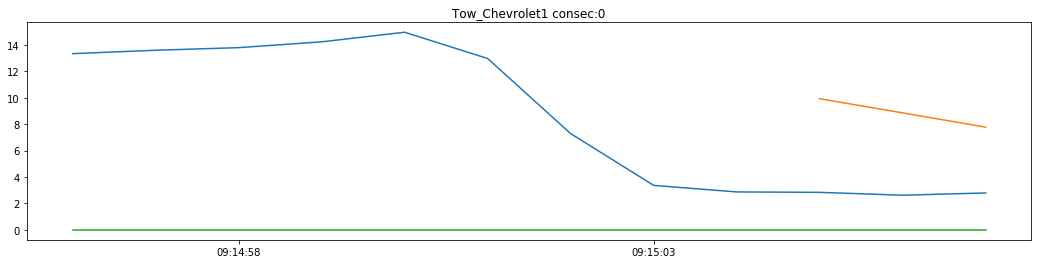

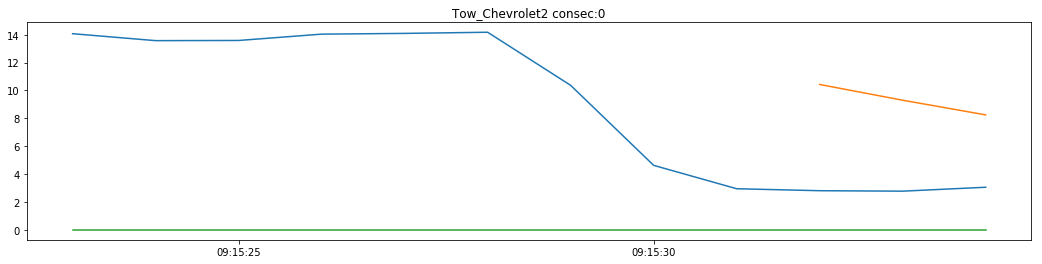

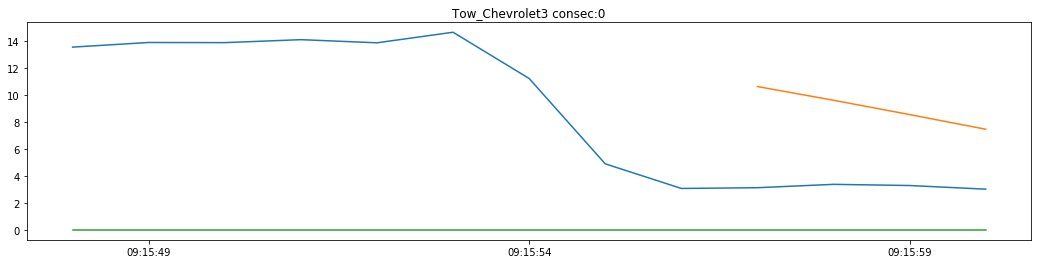

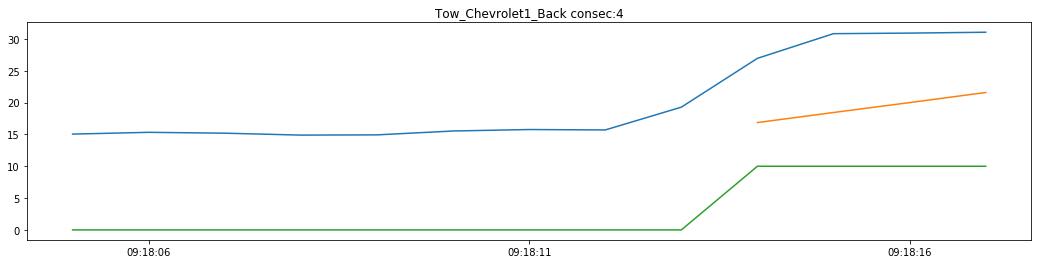

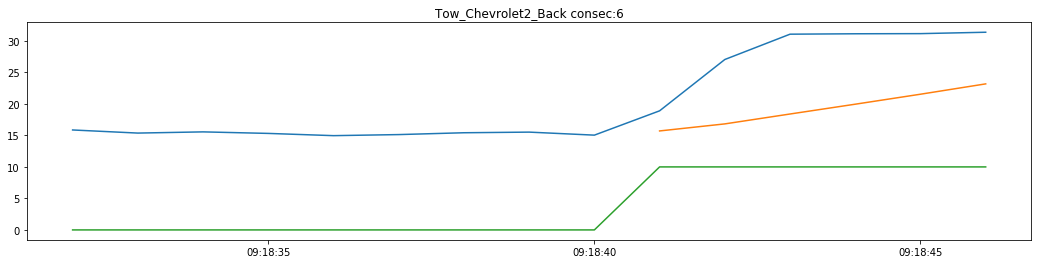

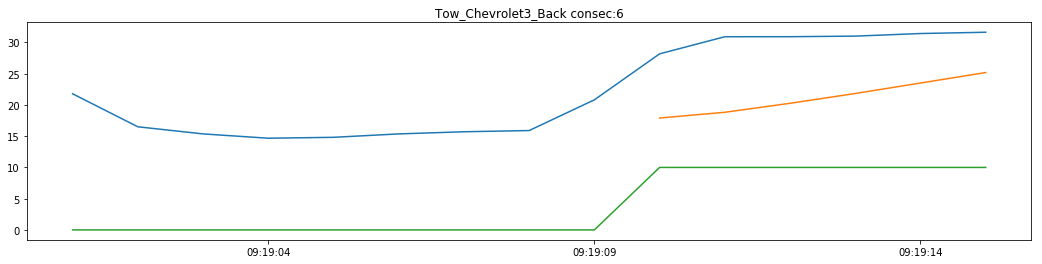

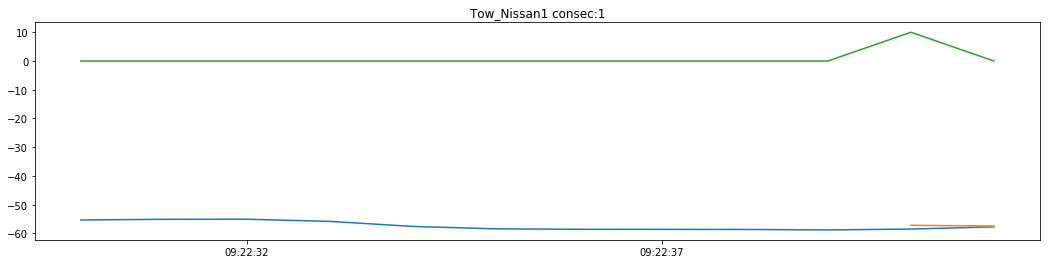

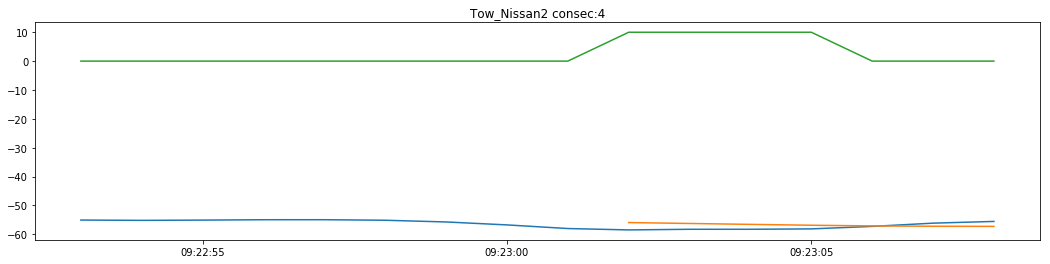

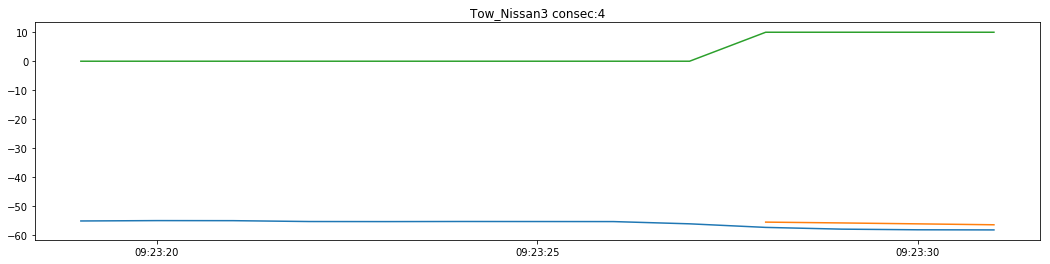

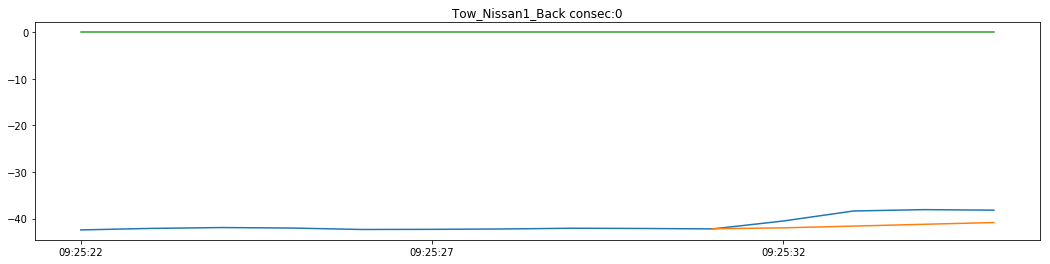

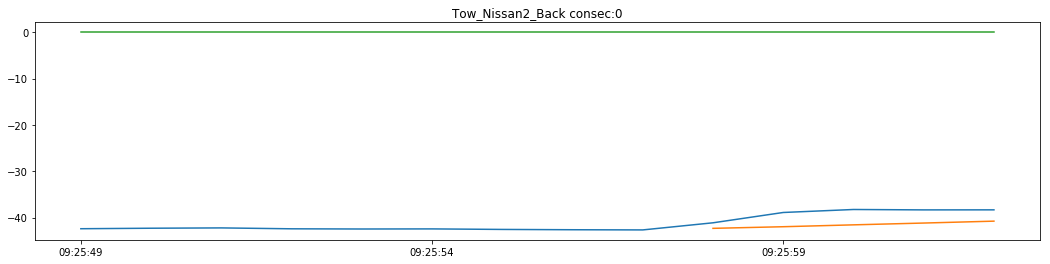

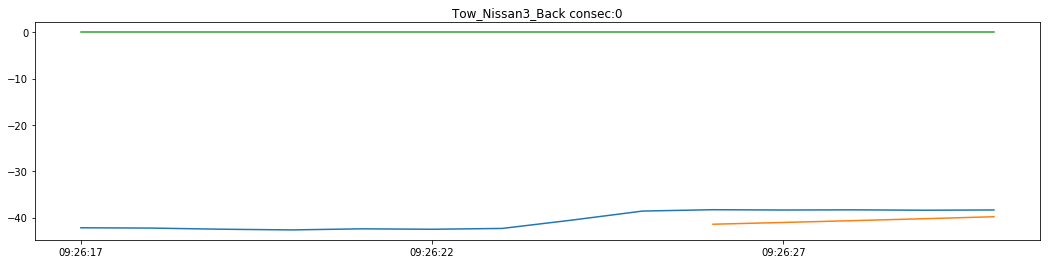

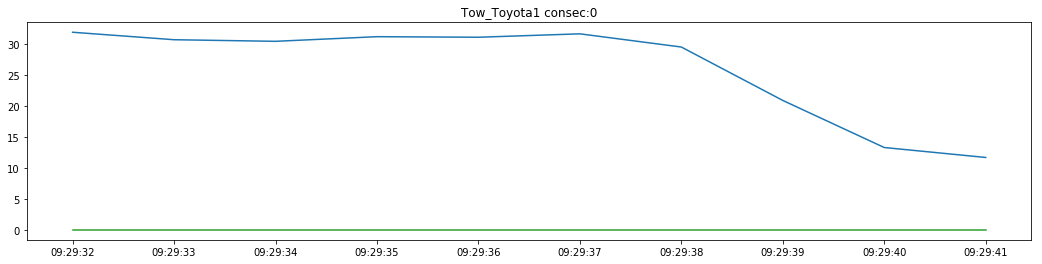

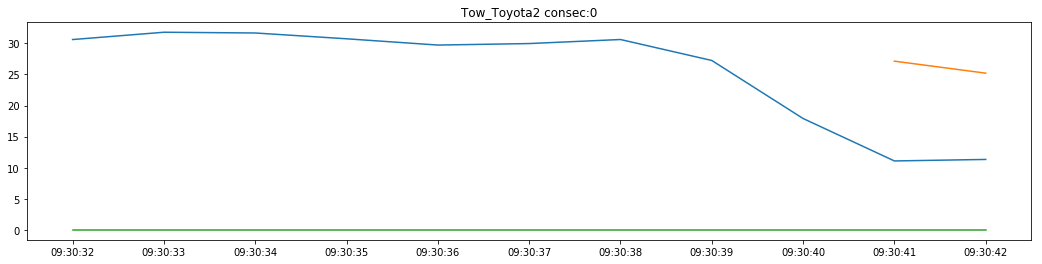

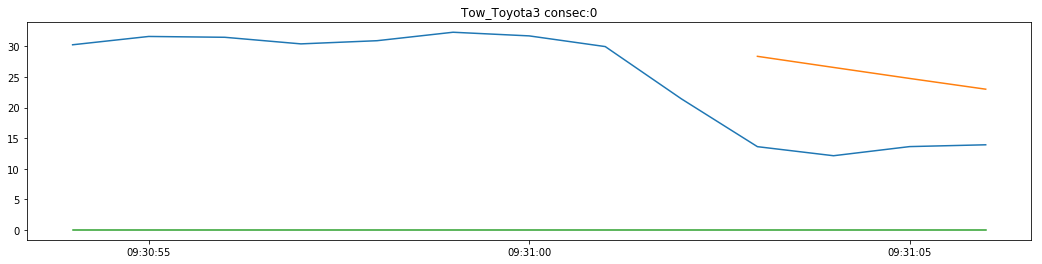

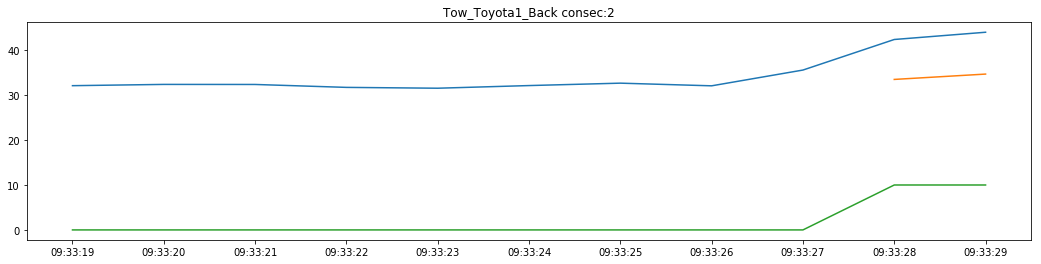

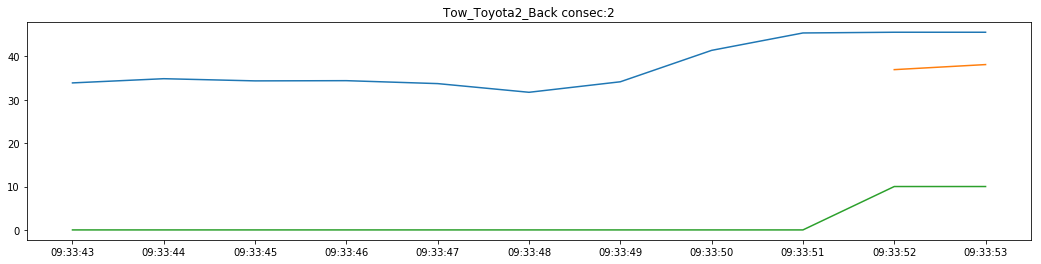

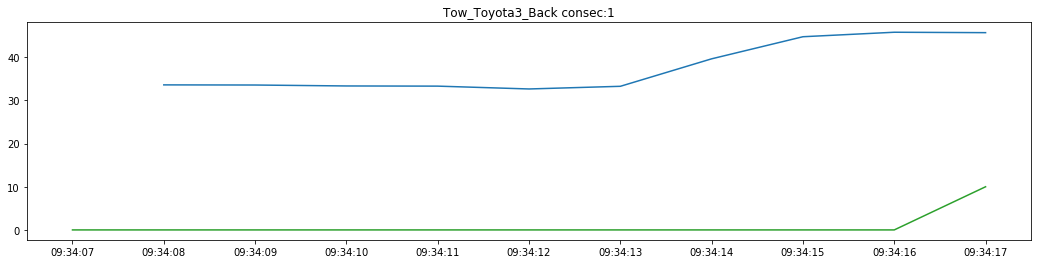

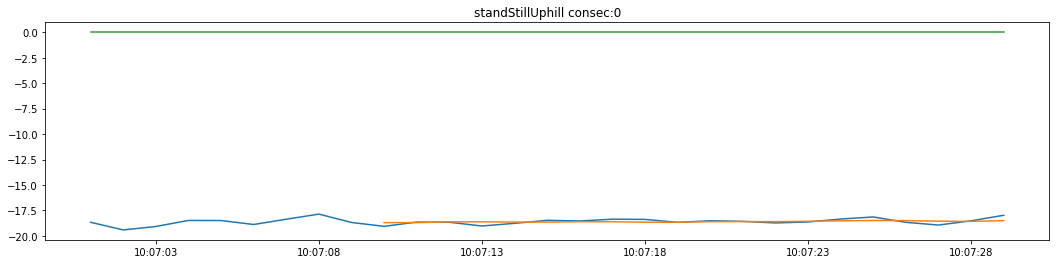

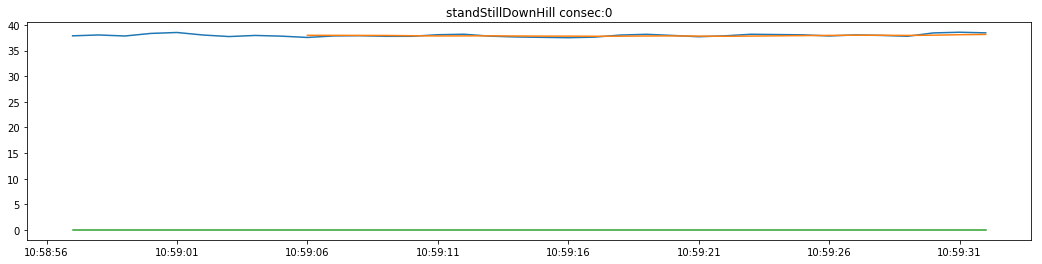

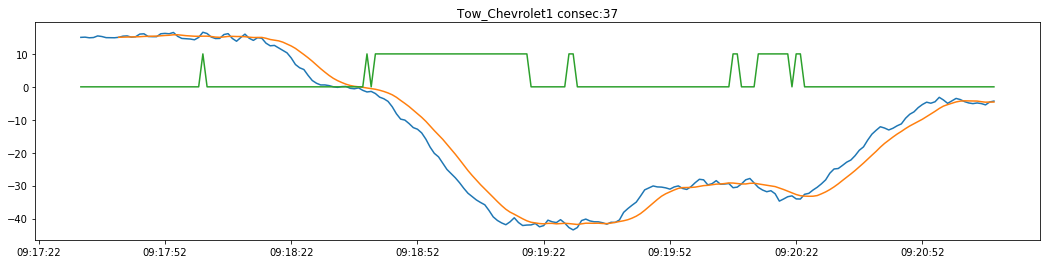

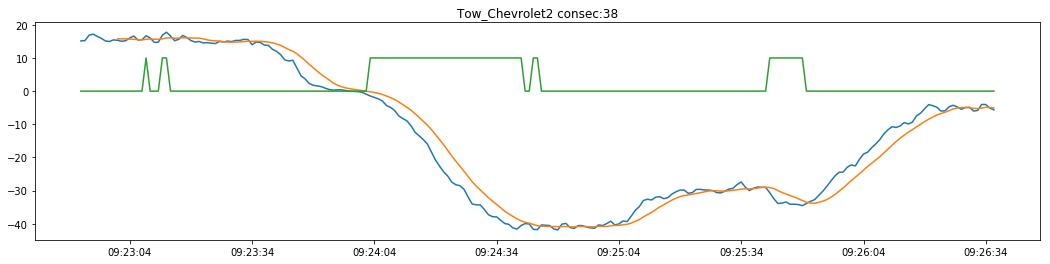

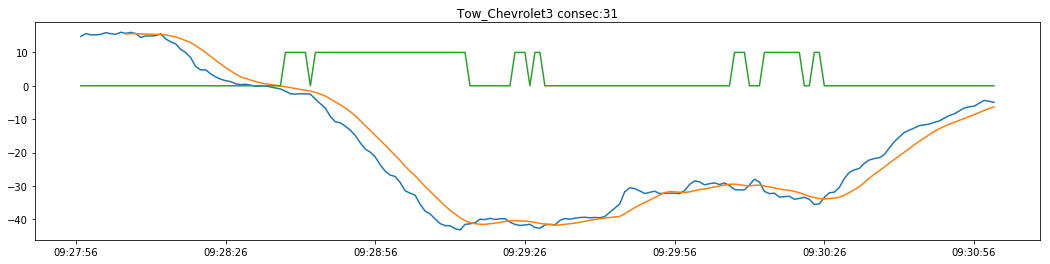

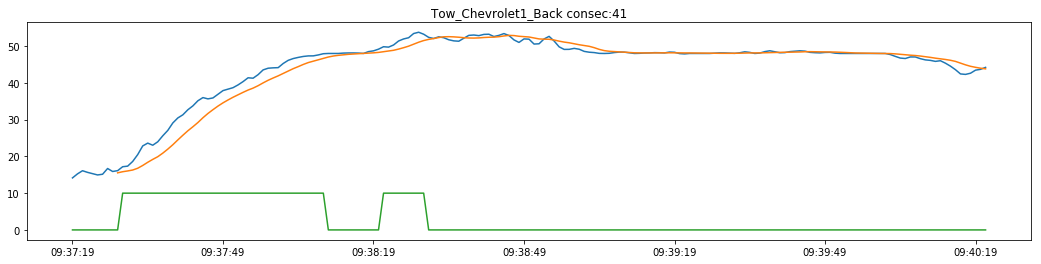

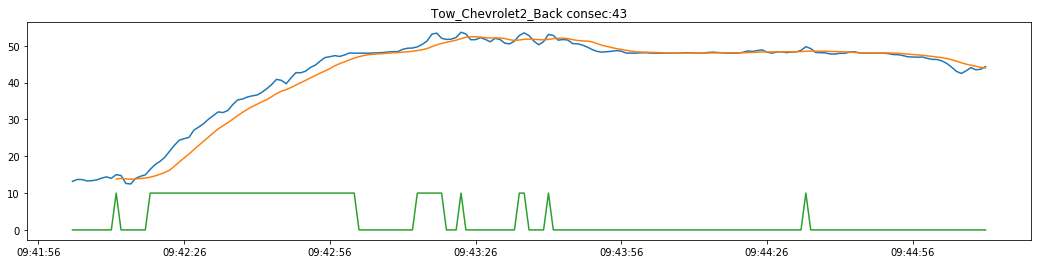

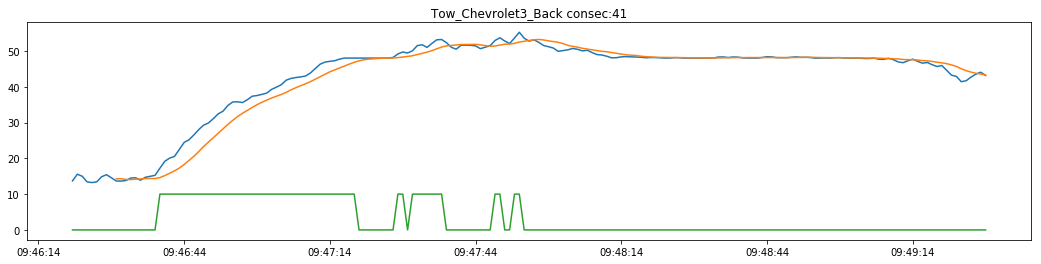

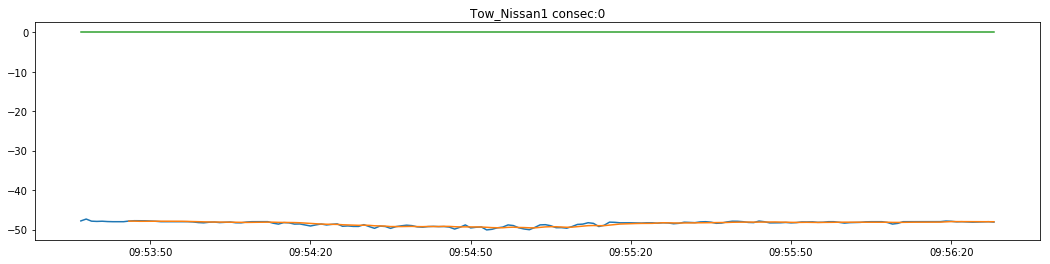

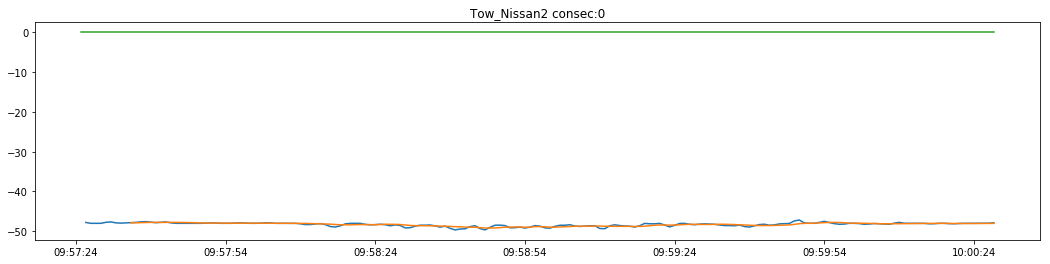

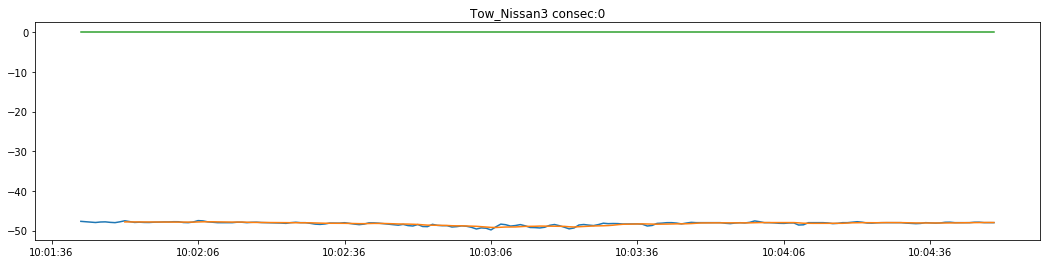

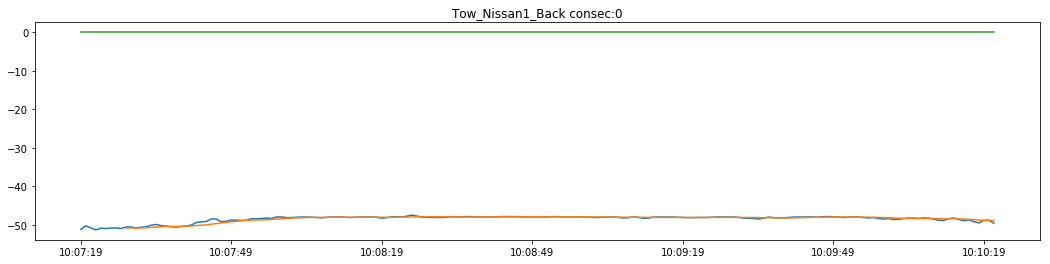

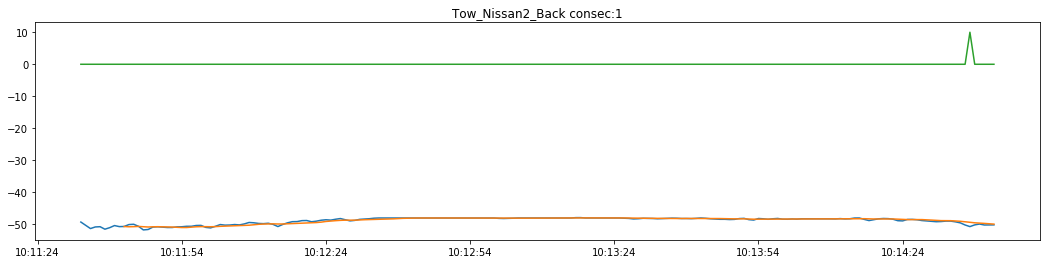

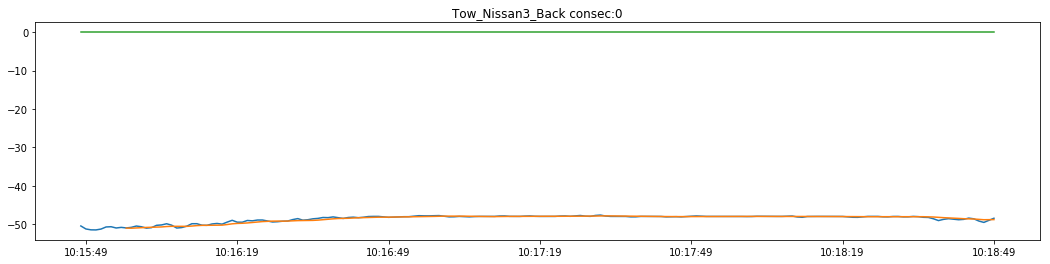

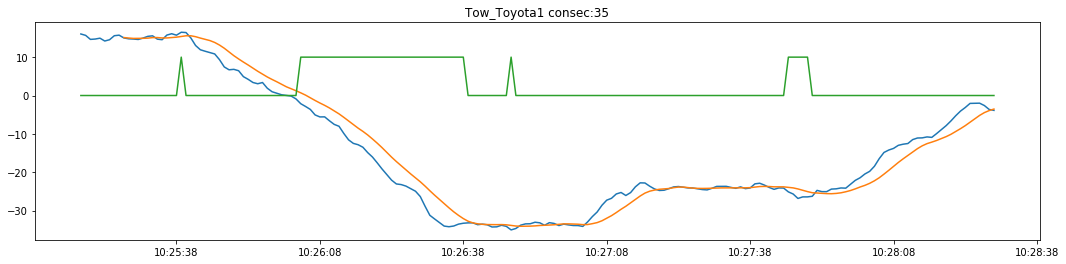

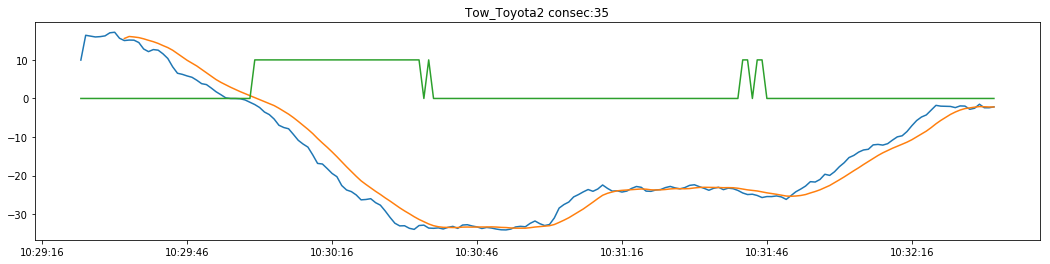

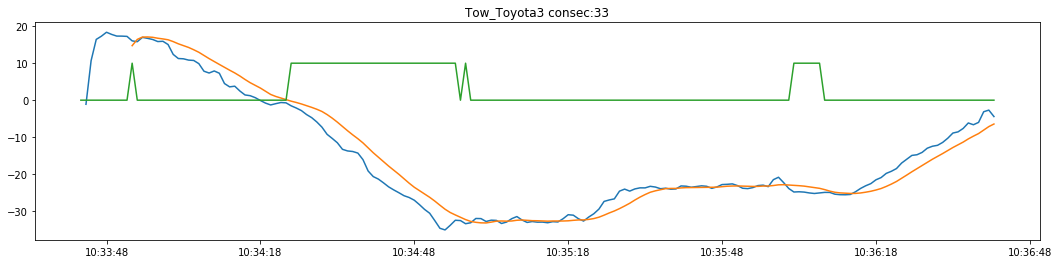

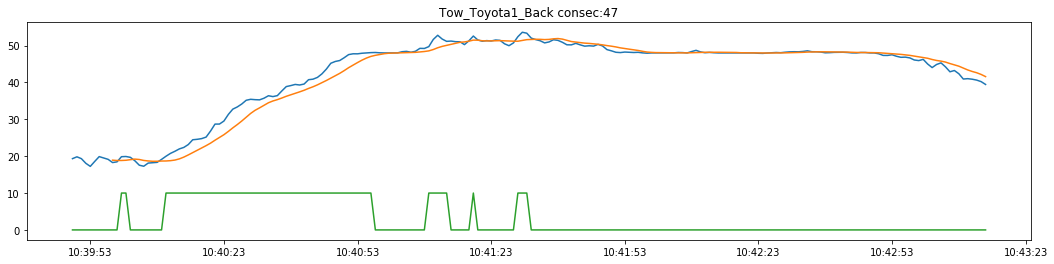

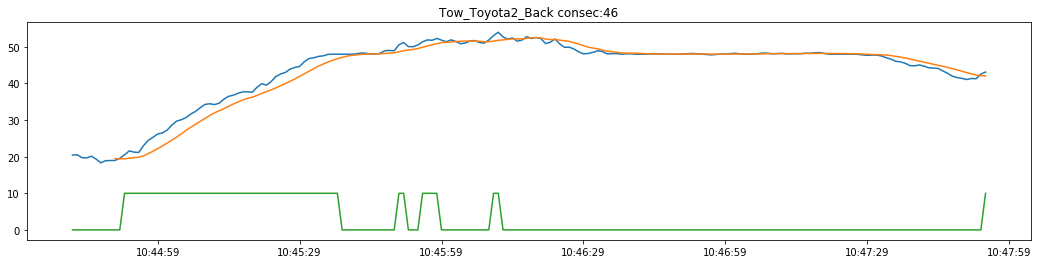

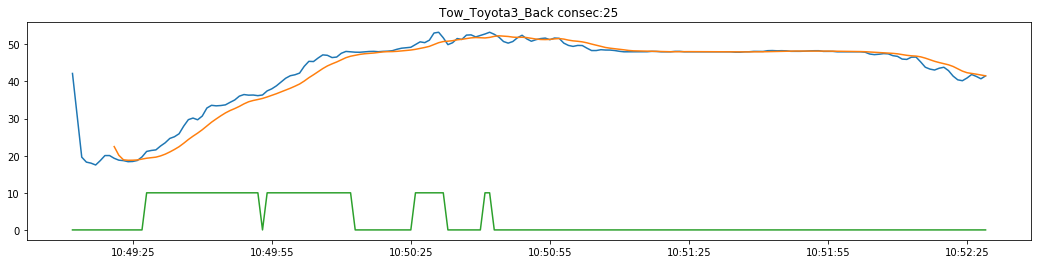

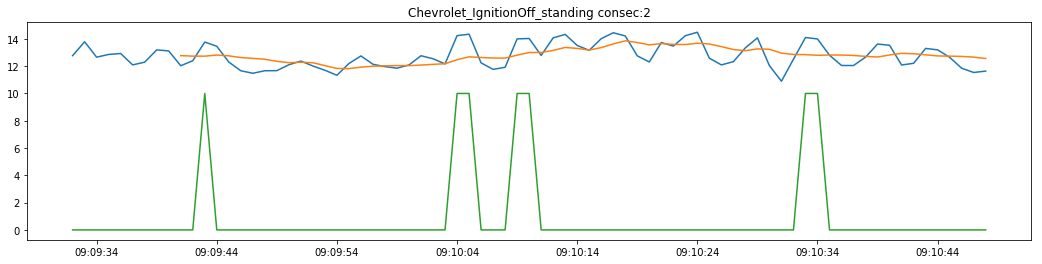

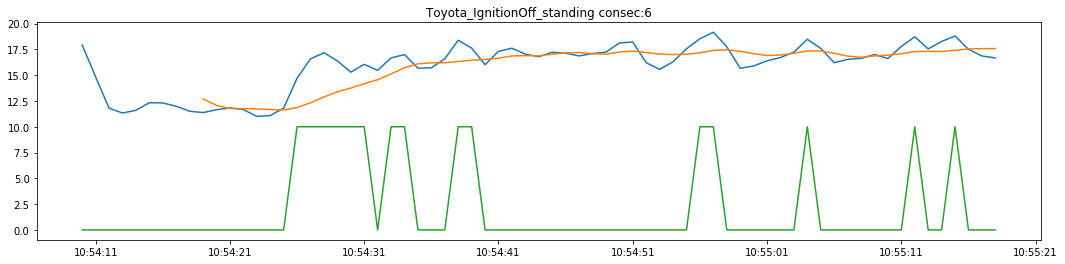

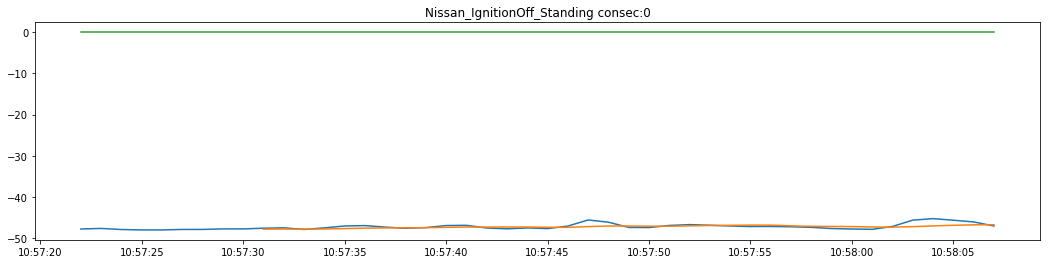

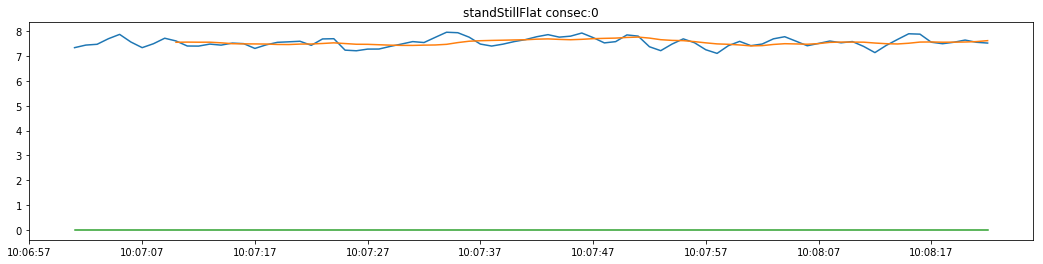

In [26]:
first_level=100
second_level=10
consec_thresh=25
axis='Forward'

rows = big_df[['sheet','file']].drop_duplicates().iterrows()
for row in rows: 
    sheet = row[1][0]
    file = row[1][1]
    rolling = pd.DataFrame(big_df[(big_df.sheet==sheet)&(big_df.file==file)][axis].rolling(first_level).mean())
    rolling['time_sec'] = rolling.index.round('s')

    grouped = rolling.groupby('time_sec').mean()
    mean = grouped[axis].rolling(second_level).mean()
    trend = pd.DataFrame(np.abs(grouped[axis])>np.abs(mean)+1)[axis]
    consec_decreases = trend * (trend.groupby((trend != trend.shift()).cumsum()).cumcount() + 1)
    
    print(max(consec_decreases))
    fig,ax = plt.subplots(figsize=(18,4))
    ax.plot(grouped[axis])
    ax.set_title(sheet+' consec:'+str(max(consec_decreases)))
    ax.plot(mean)
    ax.plot(trend*10)
    
    if 'tow' in sheet.lower():
        print('tow',sheet,file)

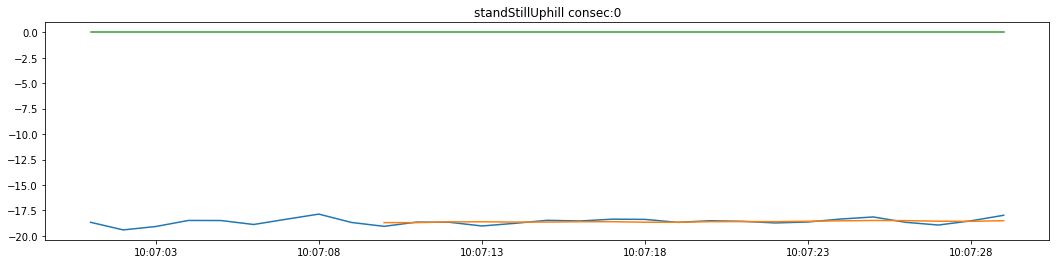

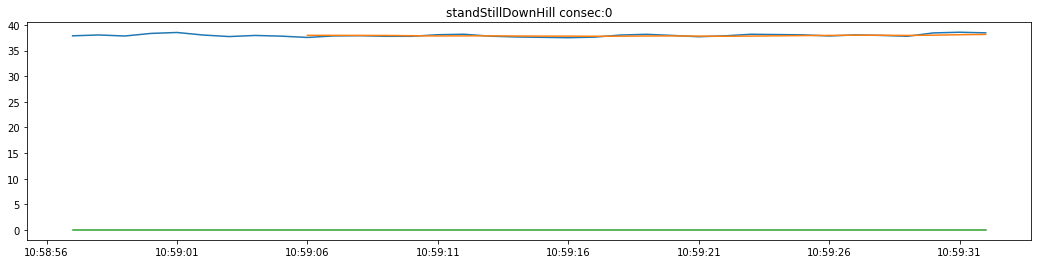

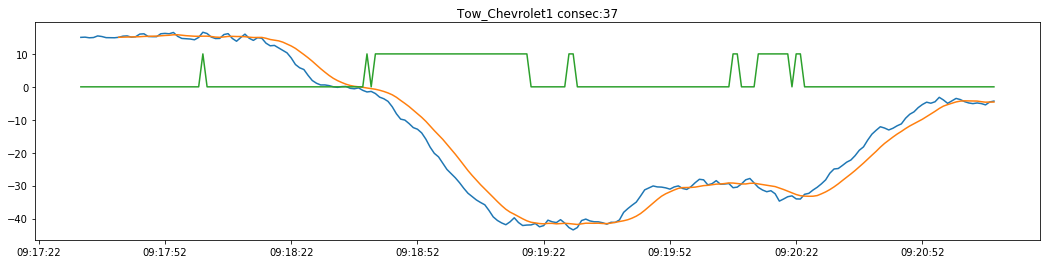

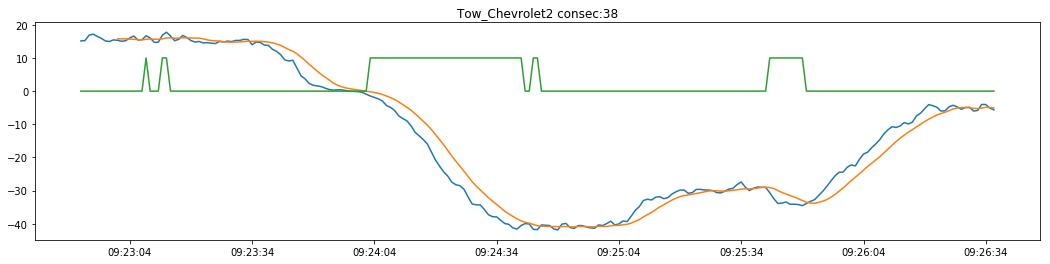

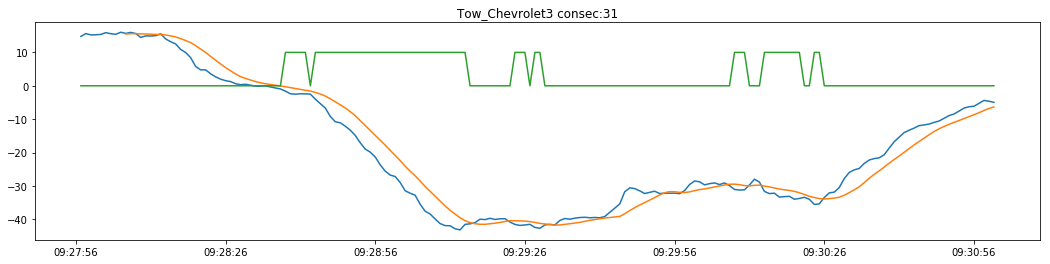

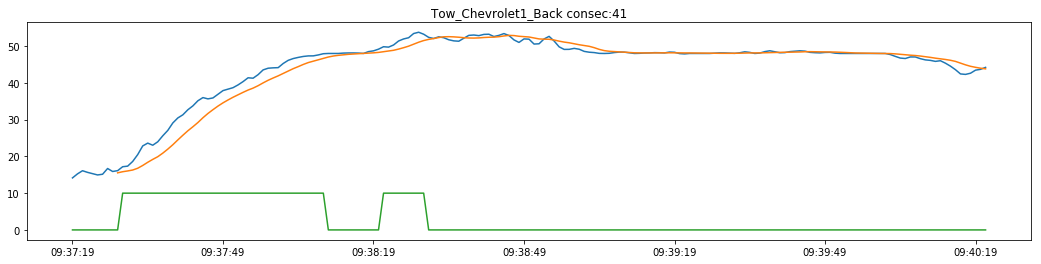

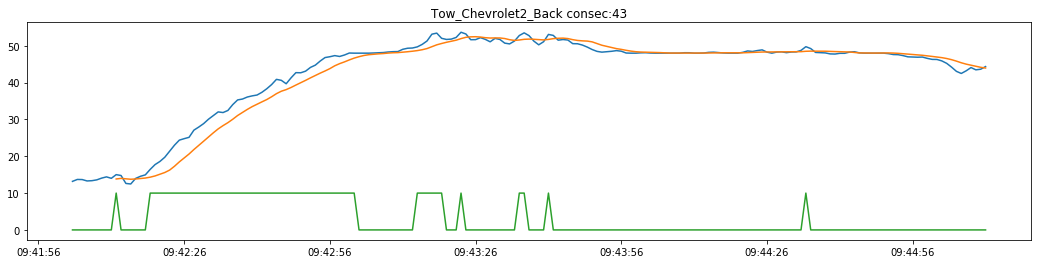

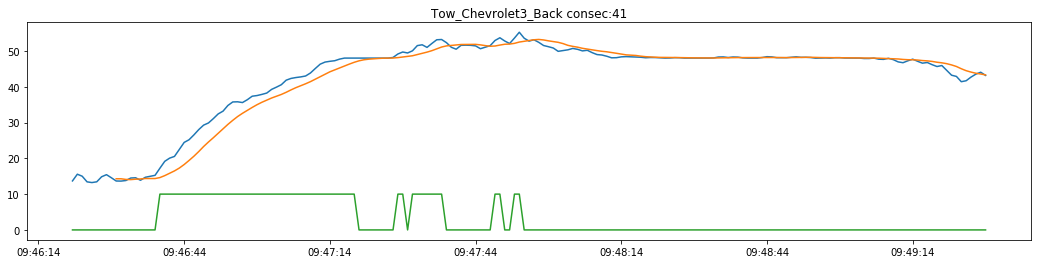

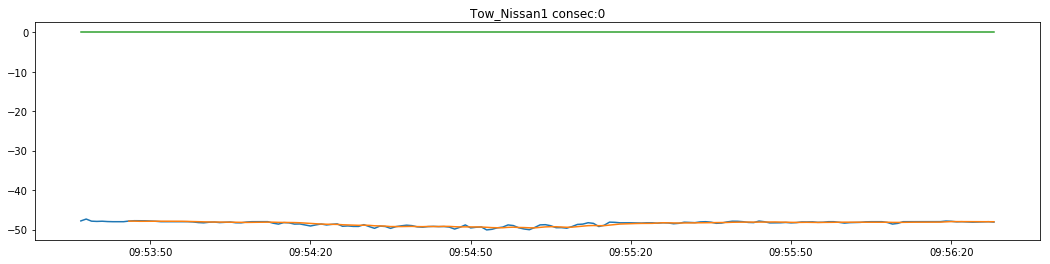

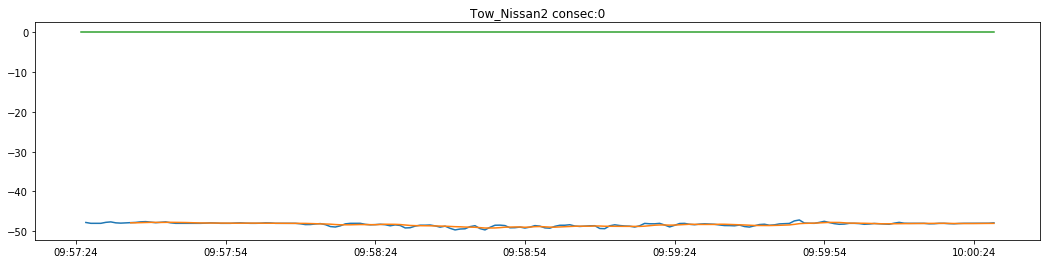

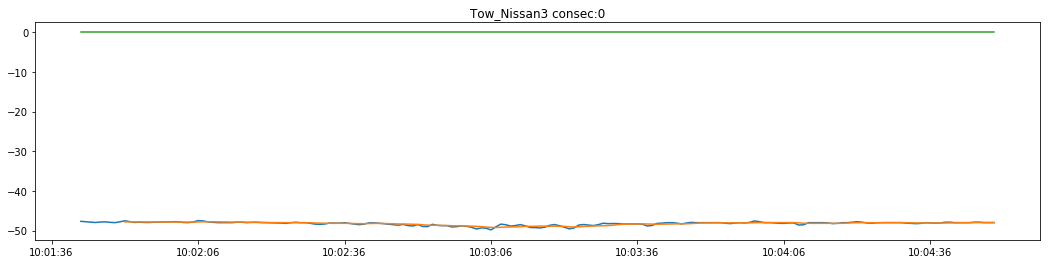

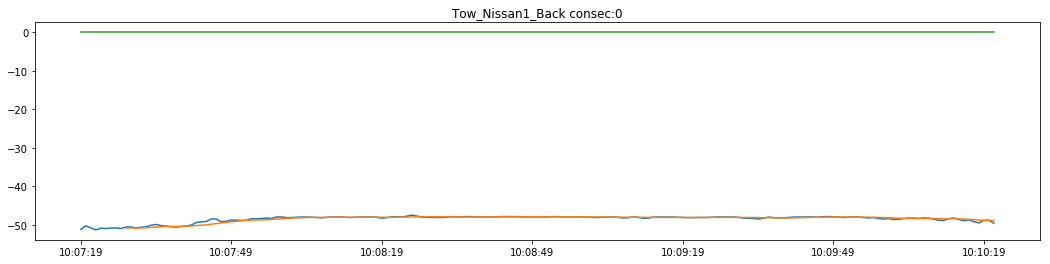

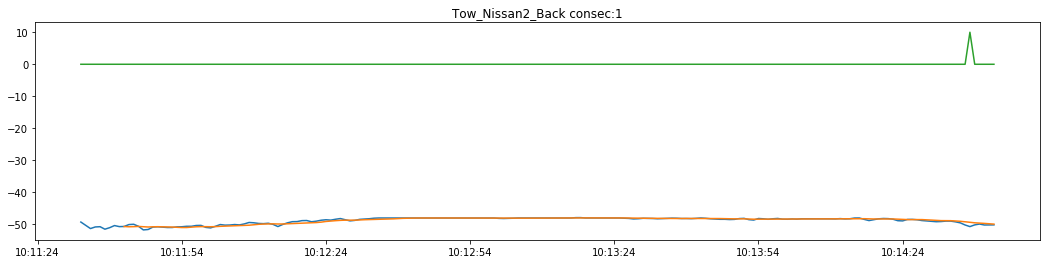

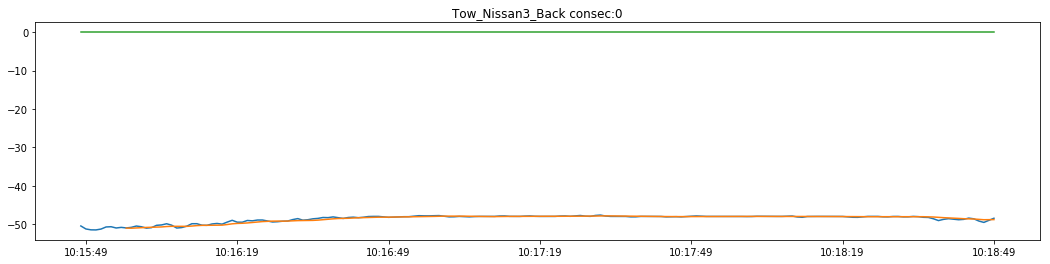

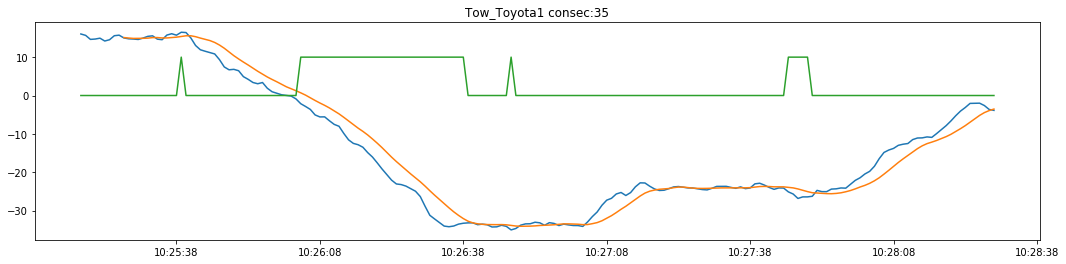

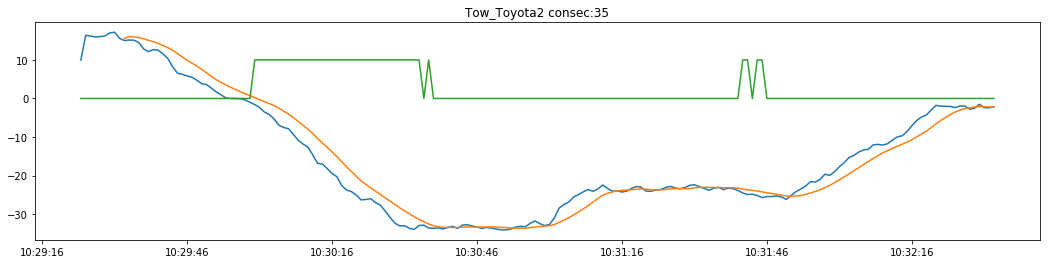

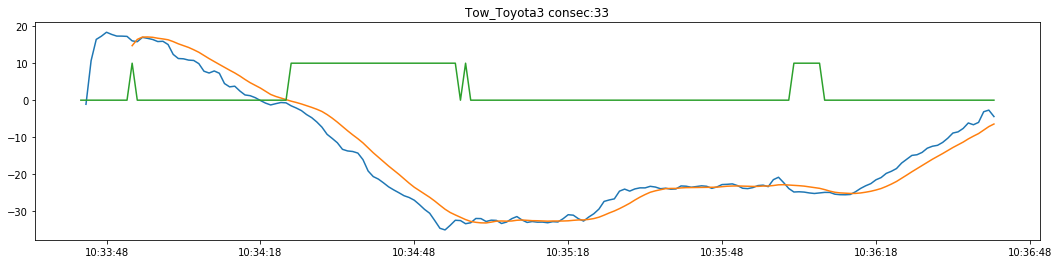

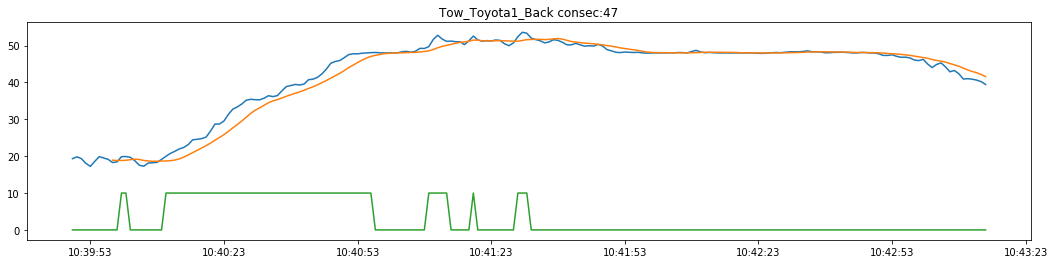

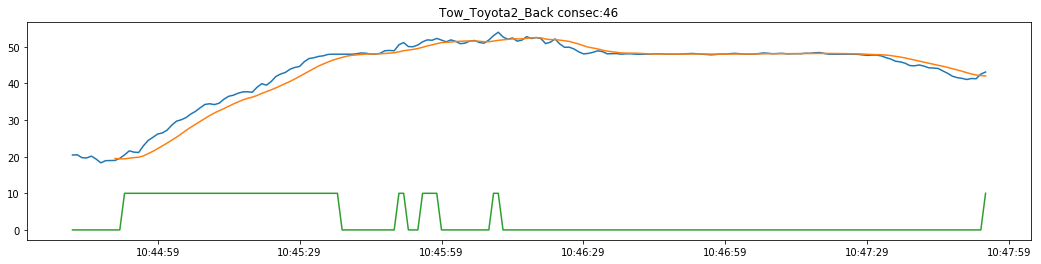

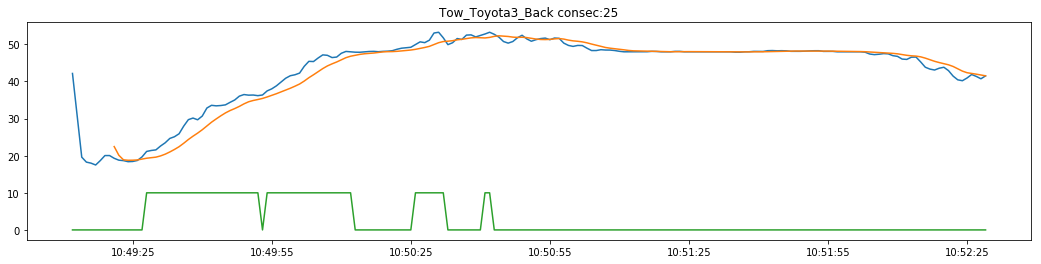

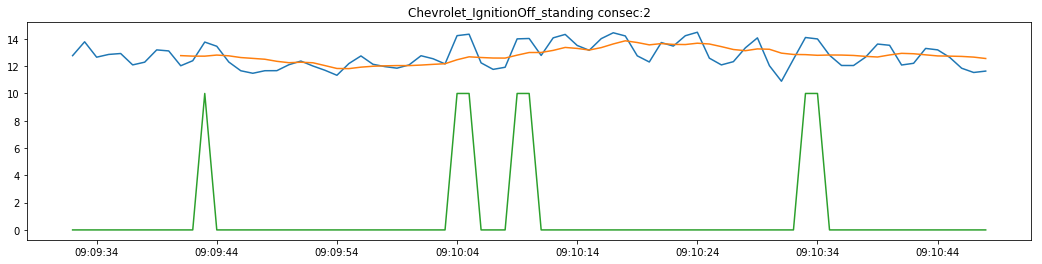

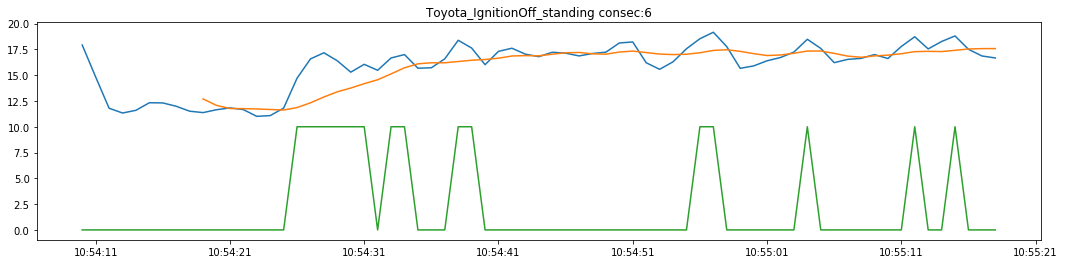

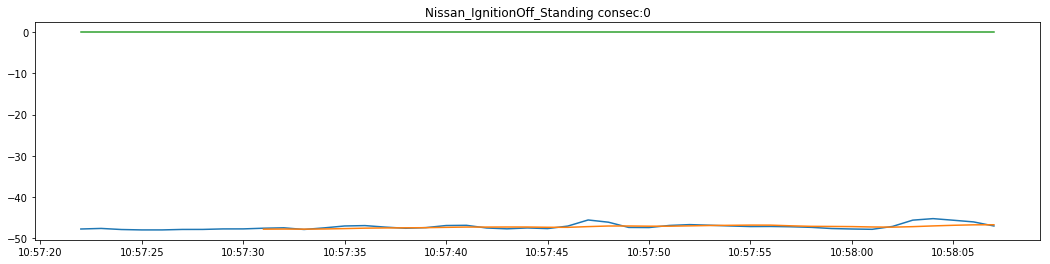

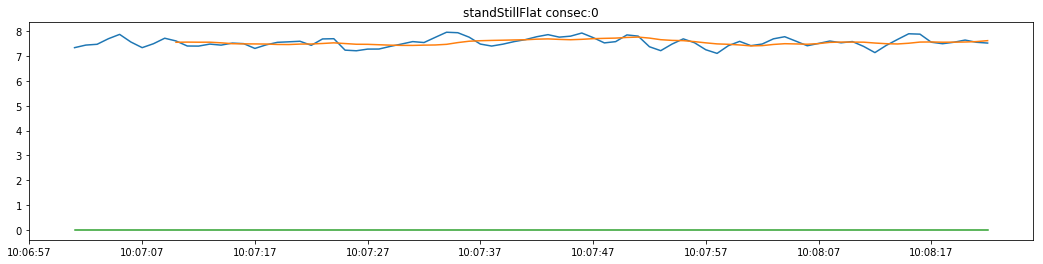

In [366]:
mean_crossing(big_df, axis='Forward')

## Strange pattern recognition library

In [7]:
cd ~/cloned_libs/time-series-pattern-recognition/

/home/gidi/cloned_libs/time-series-pattern-recognition


In [9]:
import operator
from src.generated.generated import *

In [10]:
data = [4,3,5,5,2,1,1,3,3,4,6,6,3,1,3,3]
min_min_increasing_sequence(data)

1

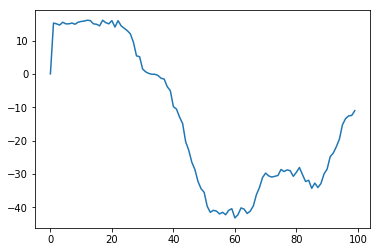

In [43]:

plt.plot(data)

In [12]:
from src.generated import generated

In [12]:
data=[1,1,1]

In [30]:
for i in range(8,len(dir(generated))):
    print(dir(generated)[i],eval(dir(generated)[i])(a))

max_max_decreasing 17.16
max_max_decreasing_sequence 17.16
max_max_decreasing_terrace 16.92
max_max_dip_on_increasing_sequence -6.96
max_max_gorge 17.04
max_max_increasing 17.16
max_max_increasing_sequence 17.16
max_max_increasing_terrace 16.8
max_max_inflexion 17.16
max_max_peak 17.16
max_max_plain 16.68
max_max_plateau 17.16
max_max_proper_plain 16.68
max_max_proper_plateau 17.16
max_max_steady 17.16
max_max_steady_sequence 17.16
max_max_strictly_decreasing_sequence 17.16
max_max_strictly_increasing_sequence 17.16
max_max_summit 16.92
max_max_valley 17.04
max_max_zigzag 15.72
max_min_bump_on_decreasing_sequence -3.84
max_min_decreasing 17.04
max_min_decreasing_sequence 16.68
max_min_decreasing_terrace 16.92
max_min_dip_on_increasing_sequence -7.08
max_min_gorge 16.68
max_min_increasing 17.04
max_min_increasing_sequence 16.68
max_min_increasing_terrace 16.8
max_min_inflexion 16.8
max_min_peak 16.8
max_min_plain 16.68
max_min_plateau 17.16
max_min_proper_plain 16.68
max_min_proper_plat

TypeError: '>' not supported between instances of 'tuple' and 'int'

## Predict slight towings

In [359]:
research_dfa=big_df.groupby('time_sec')[features].mean()\
    .join(big_df.groupby('time_sec')[features].std(), rsuffix='_std')

In [360]:
len(research_dfa)

3776

In [361]:
research_dfa=research_dfa.join(big_df.groupby('time_sec')[features].max(), rsuffix='_max')

In [362]:
len(research_dfa)

3776

In [272]:
# extract features
features=['Vertical','Radial','Forward','Speed']
research_dfa = big_df.groupby('time_sec')[features].mean()\
    .join(big_df.groupby('time_sec')[features].std(), rsuffix='_std')\
    .join(big_df.groupby('time_sec')[features].max(), rsuffix='_max')\
    .join(big_df.groupby('time_sec')[features].min(), rsuffix='_min')\
    .join(big_df.groupby('time_sec')['cat_id'].max())\
    #.join(big_df.groupby('time_sec')['bumper_on'].max())\
    #.join(big_df.groupby('time_sec')['hard_stop_on'].max())
    
research_dfa = research_dfa.fillna(0)

In [273]:
Counter(research_dfa.cat_id)

Counter({1: 246, 6: 3530})

In [183]:
def get_pred_features(shift=False,moved=False,peaks=False,std=False,vert=False):

    base_feautres=['Vertical','Radial','Forward','Speed']
    func =['_max','_min','_std','']
    #for func in ['max','min','std','']:
    features=[feat+func for feat,func in itertools.product(base_feautres,func)]
    if vert:
         features=[feat+func for feat,func in itertools.product(base_feautres,func) if 'Vert' in feat]
    if std:
        features=[feat+func for feat,func in itertools.product(base_feautres,func) if 'std' in func]

    if moved:
        features+=[feat+'_moved' for feat in features if not 'shifted' in feat]
    if shift:
        
        features+=[feat+'_shifted' for feat in features if not 'moved' in feat]
    if peaks:
        features+=['speed_peaks','speed_valleys','vert_peaks','vert_valleys']

    return features

In [187]:
pred_features=get_pred_features(shift=False, moved=False)

In [ ]:
# now with better annotation

In [275]:
anot_file = '../data/Roadtrack_tags - Acc_Data_240418.csv'

anot={}

anot = pd.read_csv(anot_file)
    

events = anot[(anot.event=='tow')&(anot.file=='Acc_Data_Tow_1605')]
# fit date time format. first workout hard stops
events['start time']=pd.to_datetime(events['start time'])
events['end time']=pd.to_datetime(events['end time'])

In [276]:
research_dfa['towing']=0

In [277]:
for row in events.iterrows():
    #print(row[1])
    research_dfa['towing'][(research_dfa.index>row[1]['start time'])&(research_dfa.index<row[1]['end time'])\
                          &(research_dfa.cat_id==6)]=1


In [278]:
Counter(research_dfa.towing)

Counter({0: 3723, 1: 53})

In [279]:
# remove the standard tows, leave only the slight
research_dfa=research_dfa[~((research_dfa.cat_id==6)&(research_dfa.towing==0))]

In [280]:
Counter(research_dfa.towing)

Counter({0: 246, 1: 53})

In [309]:
# multi layer perceptron - neural network

estimators=5

mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15, 10), random_state=1)
#lr = LogisticRegression()
#svc = svm.SVC(decision_function_shape='ovo')
# tree based models
et = ExtraTreesClassifier(n_estimators=estimators, random_state=0)
base_estimator = DecisionTreeClassifier(max_depth=4, random_state=0)
ada = AdaBoostClassifier(n_estimators=estimators,random_state=0)
rf = RandomForestClassifier(n_estimators=estimators,max_depth=10, oob_score=True, random_state=1)

models = [rf,ada,et]
model_names = ['random forest', 'ada', 'extra tree']

print('feature count', len(pred_features))
print('estimator count',estimators)
kf = KFold(n_splits=5,shuffle=True)

for i, model in enumerate(models):
    results=[]
    for samples_train, samples_test in kf.split(research_dfa):
        # SVM is much slower
        X_train,X_valid, y_train,y_valid = research_dfa[pred_features].iloc[samples_train],\
        research_dfa[pred_features].iloc[samples_test]\
        ,research_dfa.towing[samples_train],research_dfa.towing[samples_test]
        model.fit(X_train,y_train)
        score = model.score(X_valid,y_valid)
        results.append(score)
#         print('')
#         print(model_names[i],round(score,3))
#         print(cm(model.predict(X_valid),y_valid))
    print(model_names[i],round(np.mean(results),3),round(np.std(results),3))
    

feature count 16
estimator count 5
random forest 0.923 0.067
ada 0.916 0.021
extra tree 0.983 0.015


In [310]:
port_model(model,'test.cpp')

model size in bytes is:  47533


In [342]:
# functionize stuff

def init_model(type='et',params={'estimators':5}):
    if type=='mlp':
        model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15, 10), random_state=1)
    elif type=='lr':
        model = LogisticRegression()
    elif type=='svc':
        model = svm.SVC(decision_function_shape='ovo')
        # tree based models
    elif type=='et':
        model = ExtraTreesClassifier(n_estimators = params['estimators'], random_state=0)
    elif type=='ada':
        base_estimator = DecisionTreeClassifier(max_depth=4, random_state=0)
        model = AdaBoostClassifier(n_estimators = params['estimators'],random_state=0)
    elif type=='rf':
        model = RandomForestClassifier(n_estimators=params['estimators'],max_depth=10, oob_score=True, random_state=1)
    else:
        model=''
    return model


def select_model(data=research_dfa, model_names='',features=pred_features,dest='towing',params={'estimators':5}):
    # model selection script
    Counter(data.towing)
    models = [init_model(name) for name in model_names]
    print(f'predicting {dest} with {len(pred_features)} feature count')

    kf = KFold(n_splits=5,shuffle=True)
    for i, model in enumerate(models):
        results=[]
        for samples_train, samples_test in kf.split(data):

            X_trn,X_val, y_trn,y_val = data[features].iloc[samples_train],\
            data[features].iloc[samples_test] ,data[dest][samples_train],data[dest][samples_test]
            model.fit(X_trn,y_trn)
            
            score = model.score(X_val, y_val)
            results.append(score)
            
        print(model_names[i],round(np.mean(results),3),round(np.std(results),3))

In [343]:
select_model(model_names=['rf', 'ada', 'et'])

predicting towing with 16 feature count
rf 0.957 0.008
ada 0.916 0.03
et 0.973 0.017
